In [9]:
import pandas as pd
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import numpy as np
%matplotlib inline     
sns.set(color_codes=True)
from sklearn.model_selection import ShuffleSplit
import statistics
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import keras as keras
from tensorflow.keras import initializers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
# Seed value
# Apparently you may use different seed values at each stage
# seed_value= 150

# # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
# import os
# os.environ['PYTHONHASHSEED']=str(seed_value)

# # 2. Set `python` built-in pseudo-random generator at a fixed value
# import random
# random.seed(seed_value)

# # 3. Set `numpy` pseudo-random generator at a fixed value
# import numpy as np
# np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
# import tensorflow as tf
# tf.random.set_seed(seed_value)
# # for later versions: 
# # tf.compat.v1.set_random_seed(seed_value)



In [12]:
weatherData = pd.read_csv("/content/gdrive/MyDrive/ML/weatherAUS.csv")
defaultCredit = pd.read_csv("/content/gdrive/MyDrive/ML/credit_card_clients.csv")

## Process Weather Data

In [13]:
###Drop rain today na and rain tomorrow na
#code months
weatherData['Date'] = pd.to_datetime(weatherData['Date'], format='%m/%d/%Y', errors='ignore')
#filter for events between 2012 and 2016
weatherData = weatherData[(weatherData['Date'].dt.year>= 2011) & (weatherData['Date'].dt.year<=2012)]
weatherData = weatherData[weatherData['RainToday'].notna()]
weatherData = weatherData[weatherData['RainTomorrow'].notna()]
weatherData = weatherData.fillna(0.0)
#replace yes and no wiht 1 and 0 
weatherData['RainToday'] = weatherData['RainToday'].apply(lambda x: 0  if x == 'No' else 1)
weatherData['RainTomorrow'] = weatherData['RainTomorrow'].apply(lambda x: 0  if x == 'No' else 1)
weatherData['BadWeather'] = weatherData.apply(lambda x: 1.0 if ( x['Rainfall'] >= 9.65 or x['WindGustSpeed']>=60.0) else 0.0 , axis = 1)

# weatherData['TropicalDepr'] = weatherData['WindGustSpeed'].apply(lambda x: 1.0 if x >=40.0 else 0.0 )
weatherData['Date-week'] = weatherData['Date'] + pd.DateOffset(days=-1)
hurricante_df = weatherData[['Date', 'BadWeather','Location']]
weatherData = weatherData.merge(hurricante_df, how = 'inner', left_on = ['Date-week', 'Location'], right_on = ['Date', 'Location'])
weatherData = weatherData.rename(columns={"BadWeather_y": "BWTomorrow"})
weatherData = weatherData.rename(columns={"BadWeather_x": "BWToday"})

# print(weatherData[weatherData['Tropical5days'] == 1.0].shape)

weatherData = weatherData.rename(columns={"Date_x": "Date"})


In [14]:
# weatherData.to_csv("abc.csv")

In [15]:
corrdf = weatherData[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
               'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
               'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'BWToday', 'BWTomorrow']]

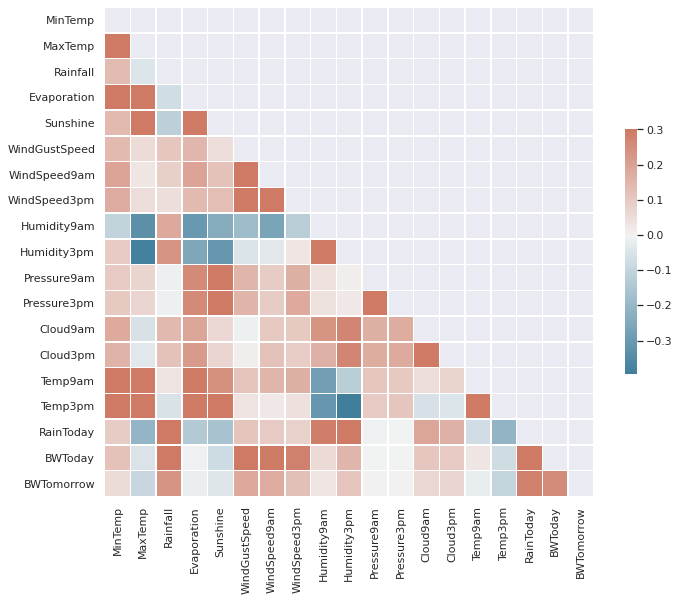

In [16]:
corr = corrdf.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [17]:
weatherData.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,BWToday,BWTomorrow
count,29516.000000,29516.000000,29516.000000,29516.000000,29516.000000,29516.00000,29516.000000,29516.000000,29516.000000,29516.000000,29516.000000,29516.000000,29516.000000,29516.000000,29516.000000,29516.000000,29516.000000,29516.000000,29516.000000,29516.000000
mean,11.613403,22.464568,2.561197,3.091703,4.475044,37.52646,13.997052,18.400020,68.257352,51.648191,922.682931,921.046707,2.711512,2.727131,16.344867,20.908863,0.232315,0.232315,0.133995,0.134876
std,6.429597,6.720705,9.267059,3.640277,4.677770,16.04653,9.050604,8.956147,20.600714,21.160030,296.070998,294.715083,3.090956,3.022264,6.441888,6.718056,0.422316,0.422316,0.340653,0.341597
min,-8.200000,-3.100000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.500000,-3.900000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,17.600000,0.000000,0.000000,0.000000,30.00000,7.000000,11.000000,57.000000,37.000000,1011.100000,1008.800000,0.000000,0.000000,11.800000,16.200000,0.000000,0.000000,0.000000,0.000000
50%,11.500000,21.900000,0.000000,2.000000,2.900000,37.00000,13.000000,17.000000,70.000000,52.000000,1016.600000,1014.300000,1.000000,1.000000,16.100000,20.400000,0.000000,0.000000,0.000000,0.000000
75%,16.400000,27.200000,0.800000,5.200000,9.200000,46.00000,19.000000,24.000000,83.000000,66.000000,1021.800000,1019.400000,6.000000,6.000000,20.900000,25.500000,0.000000,0.000000,0.000000,0.000000
max,29.100000,48.100000,367.600000,64.800000,14.300000,115.00000,65.000000,78.000000,100.000000,100.000000,1041.000000,1038.400000,9.000000,9.000000,36.800000,46.100000,1.000000,1.000000,1.000000,1.000000


Probability of Bedweather tomorrow
0.13487599945792111


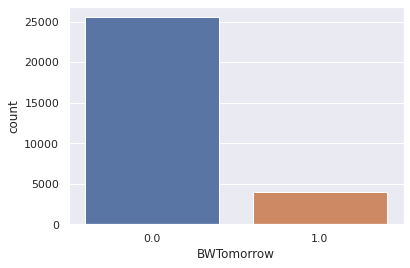

In [18]:
print("Probability of Bedweather tomorrow")
print(sum(weatherData['BWTomorrow'])/ weatherData.shape[0])
ax = sns.countplot(x="BWTomorrow", data=weatherData)

In [19]:
# sum(defaultCredit['default payment next month'])/30000

### Create 7 Day moving averages

In [20]:
columns7day = [ 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Cloud3pm', 'Temp3pm', 'BWToday']
for col in columns7day:
  title = col + "7day"
  weatherData[title] = weatherData[col].rolling(window=7).mean()
weatherData['Month'] = weatherData['Date'].dt.month

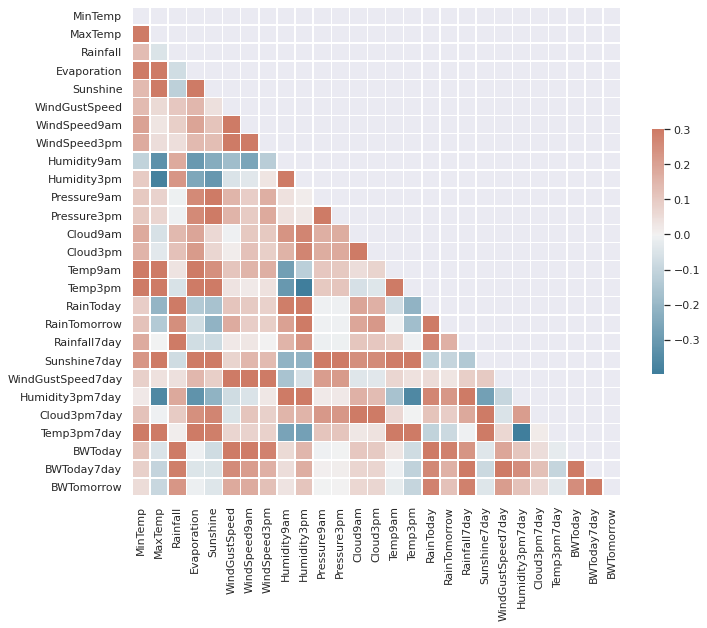

In [21]:
corrdf = weatherData[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
               'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
               'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Rainfall7day', 'Sunshine7day', 'WindGustSpeed7day', 'Humidity3pm7day',
               'Cloud3pm7day', 'Temp3pm7day', 'BWToday', 'BWToday7day', 'BWTomorrow'
               
               
               ]]
corr = corrdf.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Encode the Categoricals

In [22]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(weatherData['WindGustDir'].astype(str))
weatherData['Wind_Gust_Dir_Encoded'] = encoder.transform(weatherData['WindGustDir'].astype(str))
weatherData['WindDir3pm'] = encoder.transform(weatherData['WindDir3pm'].astype(str))
weatherData = pd.concat([weatherData, pd.get_dummies(weatherData['Region'], prefix='Region')], axis=1)
weatherData.columns

Index(['Date', 'Location', 'Region', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'BWToday',
       'Date-week', 'Date_y', 'BWTomorrow', 'Rainfall7day', 'Sunshine7day',
       'WindGustSpeed7day', 'Humidity3pm7day', 'Cloud3pm7day', 'Temp3pm7day',
       'BWToday7day', 'Month', 'Wind_Gust_Dir_Encoded', 'Region_NSW',
       'Region_NT', 'Region_QS', 'Region_SA', 'Region_TA', 'Region_VC',
       'Region_WA'],
      dtype='object')

In [23]:
from sklearn import preprocessing
minMaxCol = ['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am',
             'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
             'Rainfall7day', 'Sunshine7day', 'WindGustSpeed7day', 'Humidity3pm7day', 'Cloud3pm7day',  'BWToday7day'    
             ]
 

for col in minMaxCol:
  min_max_scaler = preprocessing.MinMaxScaler()
  weatherData[col] = min_max_scaler.fit_transform( weatherData[[col]])

maxAbsCol = ['MinTemp', 'MaxTemp', 'Temp3pm7day']
for col in maxAbsCol:
  max_abs_scaler = preprocessing.MaxAbsScaler()
  weatherData[col] = min_max_scaler.fit_transform( weatherData[[col]])

weatherData = weatherData.fillna(0.0)


In [24]:
## select Featres to train, test
nextRainData = weatherData.copy()
nextRainData.drop(['Date', 'Location', 'Region', 'WindGustDir',  'Date-week', 'Date_y', 'RainTomorrow',
                   'WindDir9am'], axis=1, inplace = True)

nexRainPredict = nextRainData['BWTomorrow']
nextRainData.drop(['BWTomorrow'], axis = 1, inplace = True)


In [25]:
# nextRainData.columns

## Process Loan Data

In [26]:
defaultCredit.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [27]:
## One hot encode Sex, education, marriage
defaultData = pd.concat([defaultCredit.drop('SEX', axis=1), pd.get_dummies(defaultCredit['SEX'], prefix = 'SEX')], axis=1).reset_index()
defaultData = pd.concat([defaultData.drop('EDUCATION', axis=1), pd.get_dummies(defaultData['EDUCATION'], prefix = 'EDUCATION')], axis=1).reset_index()
defaultData.drop(['level_0', 'ID'], axis=1, inplace = True)
defaultData = pd.concat([defaultData.drop('MARRIAGE', axis=1), pd.get_dummies(defaultData['MARRIAGE'],  prefix = 'MARRIAGE')], axis=1).reset_index()



In [28]:
defaultData.columns

Index(['level_0', 'index', 'LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'SEX_1', 'SEX_2', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3'],
      dtype='object')

Probability of Default
0.2212


36

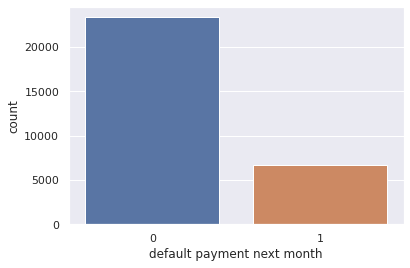

In [29]:
print("Probability of Default")
print(sum(defaultData['default payment next month'])/ defaultData.shape[0])
ax = sns.countplot(x="default payment next month", data=defaultData)
len(defaultData.columns)

In [30]:
## select Featres to train, test
defaultDataCorr = defaultData.copy()
defaultDataCorr.drop(['index',  'level_0'], axis=1, inplace = True)

In [31]:
minMaxCol = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
             'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
             
for col in minMaxCol:
  min_max_scaler = preprocessing.MinMaxScaler()
  defaultDataCorr[col] = min_max_scaler.fit_transform( defaultDataCorr[[col]])



defaultDataCorr = defaultDataCorr.fillna(0.0)

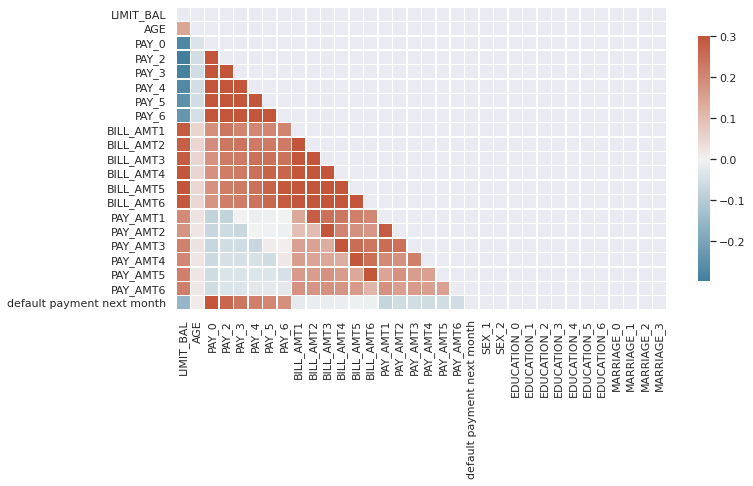

In [32]:
# test_corr = 
corr = defaultDataCorr.corr()
corr = corr.drop(['SEX_1', 'SEX_2', 'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_4','EDUCATION_3' ,'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_0','MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3' ])
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [33]:
## select Featres to train, test
defaultRun = defaultDataCorr.copy()


defaultPred = defaultRun['default payment next month']
defaultRun.drop(['default payment next month'], axis = 1, inplace = True)

In [ ]:
# defaultDataCorr.columns

# Decision Tree 

## Weather data

### Gridsearch

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict, test_size=0.1, random_state=1, shuffle = True)

In [ ]:
#get alphas


In [ ]:
def run_randomGrid(X_train, Y_train):
  tuner = dict()
  tuner['max_depth'] = [3,6,9,12,15,18,21,24,27,30]
  tuner['criterion'] = ['gini', 'entropy']
  path=DecisionTreeClassifier(criterion='gini',random_state=1).cost_complexity_pruning_path(X_train, Y_train)
  ccp_alphas, impurities = path.ccp_alphas, path.impurities
  if len(ccp_alphas)<100:
    ccp_alphas_sub = ccp_alphas
  else:
    ccp_alphas_sub = ccp_alphas[1::50]
  tuner['ccp_alpha'] = ccp_alphas_sub
  model = DecisionTreeClassifier()
  search = RandomizedSearchCV(model, tuner, n_iter=200, scoring='f1', n_jobs=-1, random_state=1)
  search = search.fit(X_train,Y_train)
  return search

In [ ]:
search_result = run_randomGrid(X_train, y_train)

In [ ]:
print(search_result.best_params_)
print(search_result.best_estimator_.score)
print(search_result.best_score_)

{'max_depth': 3, 'criterion': 'gini', 'ccp_alpha': 6.901571048536867e-05}
<bound method ClassifierMixin.score of DecisionTreeClassifier(ccp_alpha=6.901571048536867e-05, class_weight=None,
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')>
0.4992633868719323


In [ ]:
nextRainData.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'BWToday',
       'Rainfall7day', 'Sunshine7day', 'WindGustSpeed7day', 'Humidity3pm7day',
       'Cloud3pm7day', 'Temp3pm7day', 'BWToday7day', 'Month',
       'Wind_Gust_Dir_Encoded', 'Region_NSW', 'Region_NT', 'Region_QS',
       'Region_SA', 'Region_TA', 'Region_VC', 'Region_WA'],
      dtype='object')

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import statistics
def get_acc_auc_randomisedCV(X,Y,model, test_percent, iterNo=5 ):
    rs = ShuffleSplit(n_splits=5, test_size=test_percent)
    auclist = []
    train_auc_lst = []
    for train_index, test_index in rs.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        f1_val = f1_score(y_test, y_pred, average='macro')
        auclist.append(f1_val)    
        train_auc = f1_score(y_train, y_train_pred, average = 'macro')
        train_auc_lst.append(train_auc) 

        
    return (statistics.mean(auclist), statistics.mean(train_auc_lst))

model = DecisionTreeClassifier(ccp_alpha=6.901571048536867e-05, class_weight=None,
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [ ]:
def learningCurveDT(X,Y, model):
  testPercent = np.arange(0.05, 1.0, 0.05)
  testPercent = np.concatenate(( np.asarray([0.005, 0.02, 0.03]), testPercent, np.asarray([0.98,0.99, 0.995])))
  auclist = []
  for test_range in testPercent:
    auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=test_range)
    auclist.append(auc)
    print(auc)
  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
    'F1_test':pd.Series(list(zip(*auclist))[0]),
  'test_split':pd.Series(testPercent)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on Train/Test Split NextDayBadWeather")
  plt.plot('test_split','F1_train', data=d, label='F1_train')
  plt.plot('test_split','F1_test', data=d, label='F1_test')
  plt.xlabel('test_split')
  plt.xlim([1.0,0.0])
  plt.ylabel('F1_score')
  plt.ylim([0.6,0.8])
  plt.legend()

In [ ]:
learningCurveDT(nextRainData, nexRainPredict,model)
X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict, test_size=0.3, random_state=1, shuffle = True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_val = f1_score(y_test, y_pred, average='macro')
print(f1_val)

NameError: ignored

In [ ]:
#improve the bias of the decision tree
def maxDepthExp(X,Y):
  max_depth = []
  acc_gini = []
  acc_entropy = []
  for i in range(1,40):
    model = DecisionTreeClassifier(ccp_alpha=6.901571048536867e-05, class_weight=None,
                        criterion='entropy', max_depth=i, max_features=None,
                        max_leaf_nodes=None, min_impurity_decrease=0.0,
                        min_impurity_split=None)
    auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.1)
    acc_entropy.append(auc)
    max_depth.append(i)

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
  'max_depth':pd.Series(max_depth)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on MaxDepth NextDayBadWeather")
  plt.plot('max_depth','F1_train', data=d, label='F1_train')
  plt.plot('max_depth','F1_test', data=d, label='F1_test')
  plt.xlabel('Max_depth')
  plt.ylabel('F1_score')
  plt.ylim([0.6,1.1])
  plt.legend()


In [ ]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'BWToday',
       'Rainfall7day', 'Sunshine7day', 'WindGustSpeed7day', 'Humidity3pm7day',
       'Cloud3pm7day', 'Temp3pm7day', 'BWToday7day', 'Month',
       'Wind_Gust_Dir_Encoded', 'Region_NSW', 'Region_NT', 'Region_QS',
       'Region_SA', 'Region_TA', 'Region_VC', 'Region_WA'],
      dtype='object')

sds


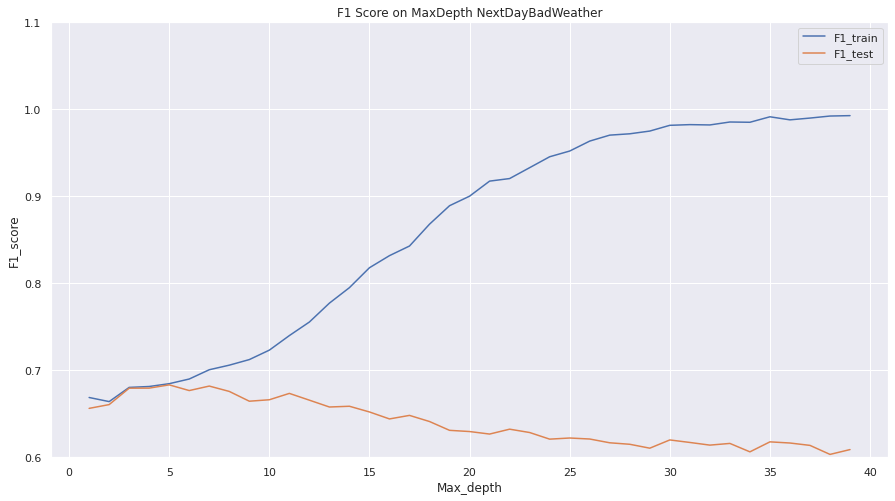

In [ ]:
maxDepthExp(X_train, y_train)
# d

(0.6925718843607626, 0.7008648167255194)
(0.6691178037907576, 0.699722077194847)
(0.6928913210814348, 0.6997954266934787)
(0.675555087657182, 0.6876744590846264)
(0.679733506470246, 0.691209778265459)
(0.6790281195553854, 0.6961319855477434)
(0.692048108582276, 0.7038434959029377)
(0.6773857175164554, 0.6918156141557785)
(0.68666227266869, 0.7055150492712475)
(0.6692727088792825, 0.6834074557494799)
(0.6653271003333244, 0.6802173841652612)
(0.6765058736972657, 0.6936829820984066)
(0.68297198771991, 0.7020924076228966)
(0.6760197136381197, 0.6990031746847334)
(0.6818574467780626, 0.7057707273514721)
(0.6902797088203105, 0.7142405220173608)
(0.6795306953980347, 0.7043796375528204)
(0.6792354541273293, 0.7208198756499307)
(0.6697258571941614, 0.7089430019614159)
(0.6908286249619061, 0.7552299197767194)
(0.6683939859111397, 0.7446919835557576)
(0.6553436345565655, 0.7714975493792984)
(0.6500521982605019, 0.8516058671198977)
(0.632087452602826, 0.8796548550536023)
(0.6157029146773729, 0.968

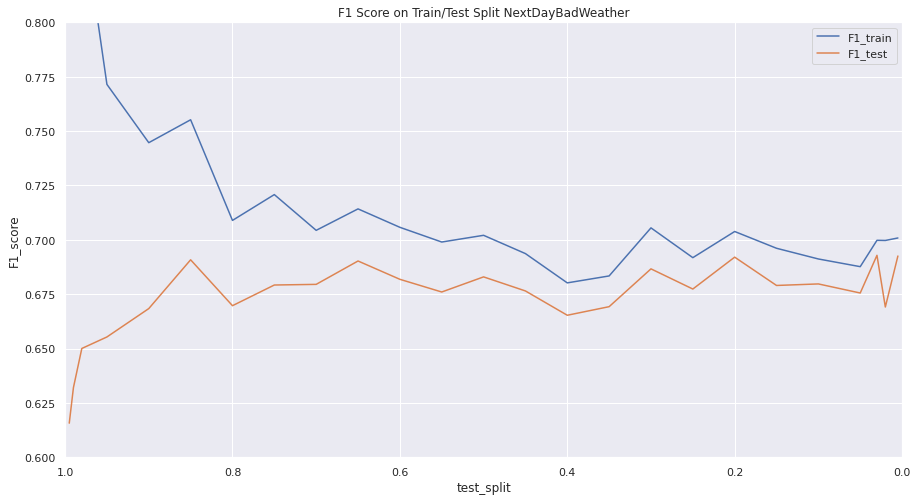

In [ ]:
#learning curves on max depth 5
model = DecisionTreeClassifier(ccp_alpha=6.942646123011841e-05, class_weight=None,
                       criterion='gini', max_depth=5, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')
learningCurveDT(nextRainData, nexRainPredict,model)

In [ ]:
def createTuner():
  path=DecisionTreeClassifier(criterion='gini',random_state=1).cost_complexity_pruning_path(X_train, y_train)
  ccp_alphas, impurities = path.ccp_alphas, path.impurities
  values = []
  ccp_alpha_upper = 6.942646123011841e-05 * 1.2
  ccp_alpha_lower = 6.942646123011841e-05 / 1.2
  value = min(range(len(ccp_alphas)), key=lambda i: abs(ccp_alphas[i]-6.942646123011841e-05))
  min_range = value - 300
  max_range = value + 300
  values = ccp_alphas[min_range:max_range:3]
  # values = [ val if (val >= ccp_alpha_lower and val <=ccp_alph_upper ) for val in ccp_alphas]
  print(len(ccp_alphas))
  print(len(values))
  return values

createTuner()

In [ ]:
# np.argmax(ccp_alphas)
# ccp_alphas[1:300:2]
# createTuner()

1697
200
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
max alphas index
48
6.584362139917695e-05
(0.6238480118628381, 0.9965611202988057)


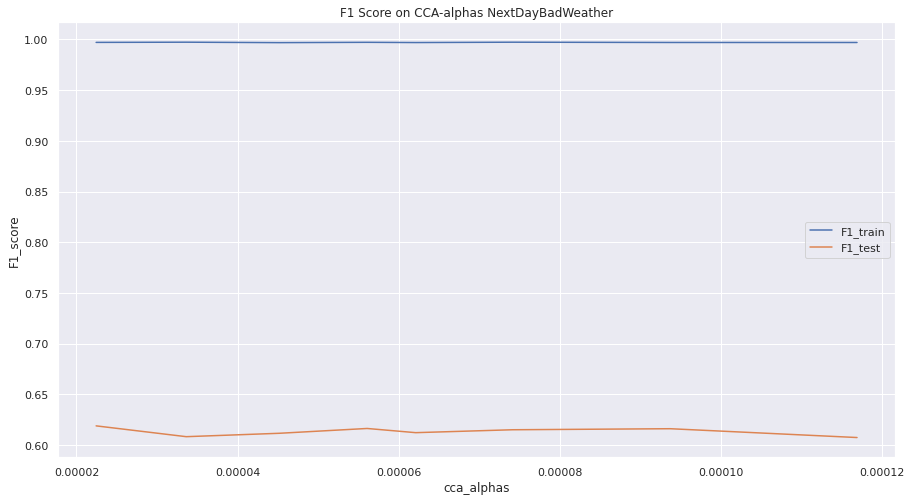

In [ ]:
##tune alphas
#improve the bias of the decision tree
def alphaTuning(X,Y):
  values = createTuner()
  max_depth = []
  acc_gini = []
  acc_entropy = []
  counter = 0
  for i in values:
    model = DecisionTreeClassifier(ccp_alpha=i, class_weight=None,
                        criterion='entropy')
    auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.1)
    acc_entropy.append(auc)
    counter +=1
    print(counter)

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
  'cca_alphas':pd.Series(ccp_alphas_sub)})
  print("max alphas index")
  print(np.argmax(np.asarray(list(zip(*acc_entropy))[0])))
  print(values[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  print(acc_entropy[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on CCA-alphas NextDayBadWeather")
  plt.plot('cca_alphas','F1_train', data=d, label='F1_train')
  plt.plot('cca_alphas','F1_test', data=d, label='F1_test')
  plt.xlabel('cca_alphas')
  plt.ylabel('F1_score')
  # plt.ylim([0.6,1.1])
  plt.legend()

alphaTuning(X_train, y_train)

In [37]:
#perform testing on test data
import time
model = DecisionTreeClassifier(ccp_alpha=6.901571048536867e-05, class_weight=None,
                       criterion='gini', max_depth=5, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')
start = timer()

model.fit(X_train, y_train)
stop = timer()

y_pred = model.predict(X_test)
f1_val = f1_score(y_test, y_pred, average='macro')
print(f1_val, stop - start)

0.6823024768230248 0.19877745500002675


In [7]:
from timeit import default_timer as timer
start = timer()
stop = timer()
diff = stop - start
diff

-3.265600003032887e-05

## Loan Data

In [ ]:
## Gridsearch
# defaultRun = defaultDataCorr.copy()


# defaultPred = defaultRun['default payment next month']
# defaultRun.drop(['default payment next month'], axis = 1, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(defaultRun, defaultPred, test_size=0.1, random_state=1, shuffle = True)

In [ ]:
search_result = run_randomGrid(X_train, y_train)
print(search_result.best_params_)
print(search_result.best_estimator_.score)
print(search_result.best_score_)

{'max_depth': 3, 'criterion': 'gini', 'ccp_alpha': 3.333333333333334e-05}
<bound method ClassifierMixin.score of DecisionTreeClassifier(ccp_alpha=3.333333333333334e-05, class_weight=None,
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')>
0.4733288263903169


(0.675677068427658, 0.6855461357642265)
(0.6980007315907599, 0.6855845797401712)
(0.6891829638010082, 0.6853926062281082)
(0.6821241646442329, 0.6863980855128663)
(0.6837935019655572, 0.6862774194774798)
(0.6887627095930641, 0.6858638530626913)
(0.6757372613287248, 0.6875395728665902)
(0.6818106060871993, 0.6868226483696506)
(0.6802008435436663, 0.683339947245384)
(0.6869072829422025, 0.6855454539165624)
(0.6817919617092375, 0.680649633058345)
(0.6773190191834931, 0.6853304658161086)
(0.6771777810184885, 0.6784003136705014)
(0.6788616624854709, 0.6780865638271802)
(0.6767462507787512, 0.6792386060449148)
(0.6769363549377803, 0.6779056591329138)
(0.6801391697684932, 0.6886019658939998)
(0.6743063900108466, 0.6847670277053006)
(0.6697908120111047, 0.6739386573328033)
(0.6784969237859357, 0.6861080981352329)
(0.6725697426227247, 0.6871176435958195)
(0.6521852821089137, 0.6792619542334812)
(0.6679089372054795, 0.7295916876673095)
(0.6361124465551186, 0.7663875873249919)
(0.6075851590533545

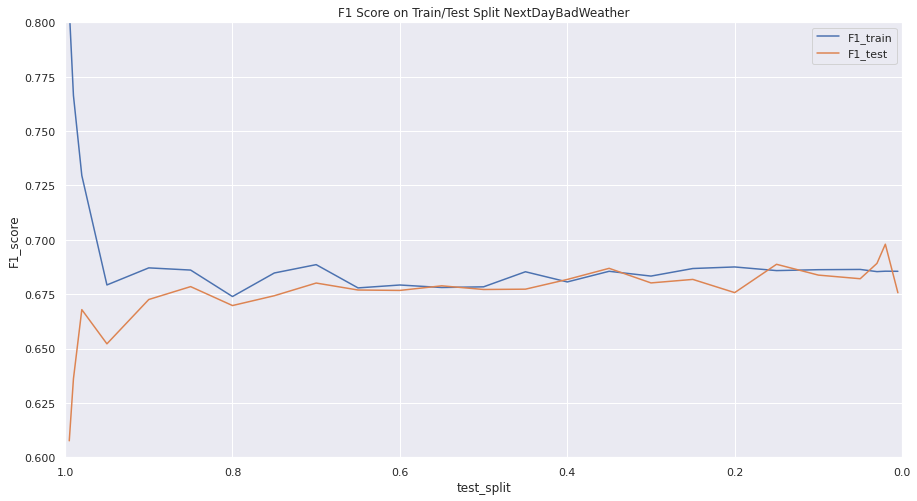

In [ ]:
model = DecisionTreeClassifier(ccp_alpha=3.333333333333334e-05, class_weight=None,
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None)
learningCurveDT(X_train,y_train, model)

In [ ]:
def createTuner():
  path=DecisionTreeClassifier(criterion='gini',random_state=1).cost_complexity_pruning_path(X_train, y_train)
  ccp_alphas, impurities = path.ccp_alphas, path.impurities
  values = []
  ccp_alpha_upper = 6.942646123011841e-05 * 1.2
  ccp_alpha_lower = 6.942646123011841e-05 / 1.2
  value = min(range(len(ccp_alphas)), key=lambda i: abs(ccp_alphas[i]-3.333333333333334e-05))
  min_range = value - 300
  max_range = value + 600

  values = ccp_alphas[value:max_range:3]
  print(ccp_alphas)
  # values = [ val if (val >= ccp_alpha_lower and val <=ccp_alph_upper ) for val in ccp_alphas]
  print(len(ccp_alphas))
  print(len(values))
  return values

[0.00000000e+00 5.43209877e-06 6.17283951e-06 ... 3.30214463e-03
 1.07222726e-02 5.15228109e-02]
1697
200
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
max alphas index
52
3.561253561253564e-05
(0.6226589805639329, 0.9991010101013816)


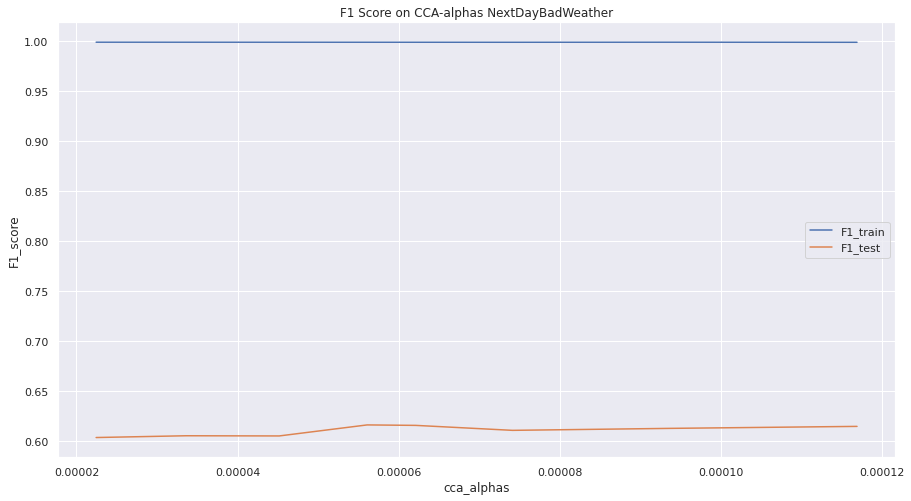

In [ ]:
# createTuner()
alphaTuning(X_train, y_train)

sds


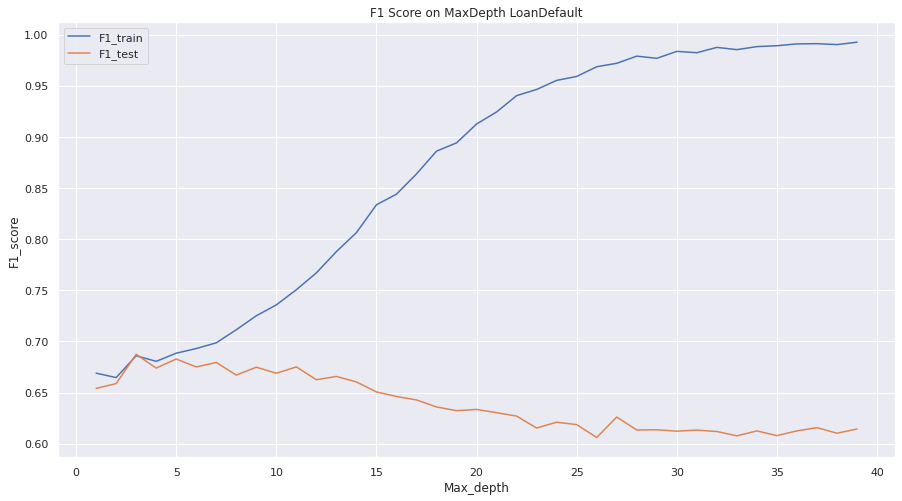

In [ ]:
#improve the bias of the decision tree
def maxDepthExp(X,Y):
  max_depth = []
  acc_gini = []
  acc_entropy = []
  for i in range(1,40):
    model = DecisionTreeClassifier(ccp_alpha=3.561253561253564e-05, class_weight=None,
                        criterion='gini', max_depth=i, max_features=None,
                        max_leaf_nodes=None, min_impurity_decrease=0.0,
                        min_impurity_split=None)
    auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.1)
    acc_entropy.append(auc)
    max_depth.append(i)

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
  'max_depth':pd.Series(max_depth)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on MaxDepth LoanDefault")
  plt.plot('max_depth','F1_train', data=d, label='F1_train')
  plt.plot('max_depth','F1_test', data=d, label='F1_test')
  plt.xlabel('Max_depth')
  plt.ylabel('F1_score')
  # plt.ylim([0.6,1.1])
  plt.legend()

maxDepthExp(X_train, y_train)

(0.6283034417752409, 0.6857842938361229)
(0.6759217473546347, 0.6855474908733942)
(0.6770214105374776, 0.6866361692431494)
(0.6979356527837053, 0.6858154759848154)
(0.6879621997668003, 0.6856105392229869)
(0.6807338080336284, 0.6869414555199552)
(0.6847656509033829, 0.6861673533310273)
(0.6831664318144995, 0.6868340076965926)
(0.6811322065002384, 0.6859820524507542)
(0.6878675161746309, 0.6846869226954738)
(0.6779121221039022, 0.6865626677046974)
(0.6826240340948928, 0.6894456153822562)
(0.6832152840793744, 0.6878898810092992)
(0.6783512439699354, 0.6851719797467127)
(0.6786204638431929, 0.6832031309266036)
(0.6817506210138294, 0.6902456711330694)
(0.6782187623608582, 0.6882139026749422)
(0.6672467502506845, 0.6745141193039608)
(0.673157628825092, 0.6795053516635093)
(0.6746563656078723, 0.6854216645088459)
(0.6738772673373502, 0.687797186710257)
(0.6682697739147748, 0.6963090365210756)
(0.6585801185383836, 0.715598407924216)
(0.6519347992841665, 0.7584303719519908)
(0.628425936551629,

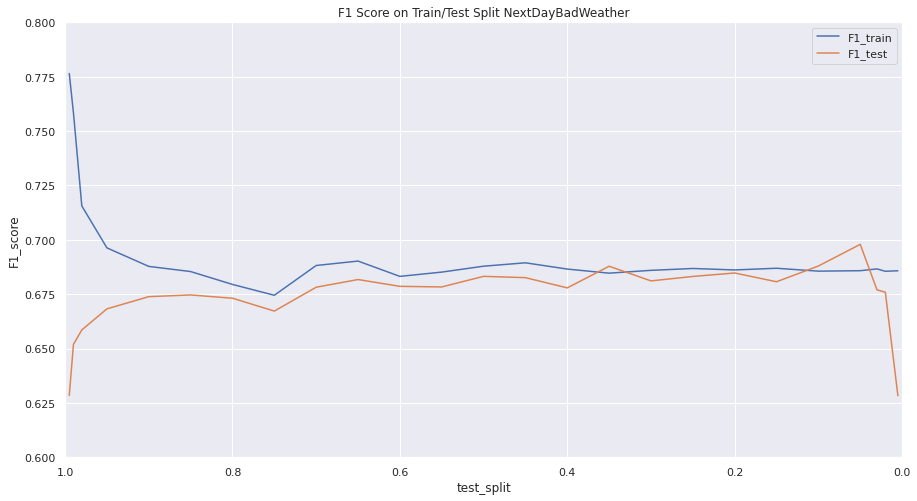

In [ ]:
model = DecisionTreeClassifier(ccp_alpha=3.561253561253564e-05, class_weight=None,
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None)
learningCurveDT(X_train,y_train, model)

In [38]:
#perform testing on test data

model = DecisionTreeClassifier(ccp_alpha=3.561253561253564e-05, class_weight=None,
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')
start = timer()
model.fit(X_train, y_train)
end = timer()
y_pred = model.predict(X_test)
f1_val = f1_score(y_test, y_pred, average='macro')
print(f1_val, end - start)

0.7075610404458382 0.16744782400007807


In [ ]:
# X_test.shape

(3000, 33)

# Neural Network

##Inclement Weather

In [40]:


import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
nextRainData = nextRainData.fillna(0.0)
encoder = LabelEncoder()
encoder.fit(nexRainPredict)
nexRainPredict_encode = encoder.transform(nexRainPredict)
nexRainPredict_encode = to_categorical(nexRainPredict_encode)

In [41]:
# nexRainPredict_encode

In [42]:
X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict_encode, test_size=0.1, random_state = 150, shuffle = True)

In [52]:
def get_f1(y_true, y_pred): #taken from old keras source code
    # y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
#credit goes to https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    # y_pred = K.round(y_pred)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def createModel():
  model =  Sequential()
  model.add(Dense(300, input_dim=35, activation='relu'))
  model.add(Dense(200, activation='relu'))
  model.add(Dense(2, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

  return model 

In [ ]:
def createModelSGD():
  model =  Sequential()
  model.add(Dense(300, input_dim=35, activation='relu'))
  model.add(Dense(200, activation='relu'))
  model.add(Dense(2, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[f1_m])

  return model 

In [ ]:
#compare ADams vs SGD
X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict_encode, test_size=0.1, shuffle = True)
model = createModel()
model.fit(X_train, y_train, epochs=50, batch_size=64,  verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
Y_test_lab = np.argmax(Y_test, axis = 1)
f1_val = f1_score(Y_test_lab, y_pred, average='macro')
print("optimizer Adams")
print(f1_val)

model = createModelSGD()
model.fit(X_train, y_train, epochs=50, batch_size=64,  verbose=0)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
f1_val = f1_score(Y_test_lab, y_pred, average='macro')
print("optimizer SGD")
print(f1_val)

optimizer Adams
0.48385669859212177
optimizer SGD
0.48369594362269597


In [ ]:
def get_acc_NN_randomisedCV(X,Y,createModel, test_percent, iterNo=5 ):
    rs = ShuffleSplit(n_splits=5, test_size=test_percent)
    auclist = []
    train_auc_lst = []
    for train_index, test_index in rs.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        model = createModel()
        model.fit(X_train, y_train, epochs=50, batch_size=64,  verbose=0)
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis = 1)
        y_train_pred = model.predict(X_train)
        y_train_pred = np.argmax(y_train_pred, axis=1)
        y_test = np.argmax(y_test, axis = 1)
        y_train = np.argmax(y_train, axis = 1)

        f1_val = f1_score(y_test, y_pred, average='macro')
        auclist.append(f1_val)    
        train_auc = f1_score(y_train, y_train_pred, average = 'macro')
        train_auc_lst.append(train_auc) 

        
    return (statistics.mean(auclist), statistics.mean(train_auc_lst))

In [ ]:
np.argmax(y_train, axis = 1)

array([0, 1, 0, ..., 0, 0, 1])

In [ ]:
def learningCurveDT(X,Y, create_model):
  testPercent = np.arange(0.05, 1.0, 0.05)
  testPercent = np.concatenate(( np.asarray([0.005, 0.02, 0.03]), testPercent, np.asarray([0.98,0.99, 0.995])))
  # testPercent = [0.85]
  auclist = []
  for test_range in testPercent:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, \
                                                  test_size=test_range, random_state = 150, shuffle = True)
    model = create_model()
    model.fit(X_train, Y_train, epochs=44, batch_size=64,  verbose=0)
    print(test_range)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1)
    y_train_pred = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred, axis = 1)


    Y_test = np.argmax(Y_test, axis = 1)
    Y_train = np.argmax(Y_train, axis = 1)
    f1_val = f1_score(Y_test, y_pred, average='macro')
    train_auc = f1_score(Y_train, y_train_pred, average = 'macro')
    f1_val, train_auc = get_acc_NN_randomisedCV(X,Y, create_model,test_range)
    auclist.append((f1_val,train_auc))
    # auc = get_acc_NN_randomisedCV(X,Y,model, test_range)
    # auclist.append(auc)
    print((train_auc,f1_val))
  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
    'F1_test':pd.Series(list(zip(*auclist))[0]),
  'test_split':pd.Series(testPercent)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on Train/Test Split NextDayBadWeather (NN)")
  plt.plot('test_split','F1_train', data=d, label='F1_train')
  plt.plot('test_split','F1_test', data=d, label='F1_test')
  plt.xlabel('test_split')
  plt.xlim([1.0,0.0])
  plt.ylabel('F1_score')
  # plt.ylim([0.6,0.8])
  plt.legend()
learningCurveDT(X_train, y_train, createModel)

Epoch 1/60
831/831 [==============================] - 3s 3ms/step - loss: 0.3470 - f1_m: 0.8713 - val_loss: 0.3097 - val_f1_m: 0.8698
Epoch 2/60
831/831 [==============================] - 2s 2ms/step - loss: 0.2913 - f1_m: 0.8779 - val_loss: 0.2795 - val_f1_m: 0.8742
Epoch 3/60
831/831 [==============================] - 2s 2ms/step - loss: 0.2735 - f1_m: 0.8774 - val_loss: 0.2741 - val_f1_m: 0.8793
Epoch 4/60
831/831 [==============================] - 2s 2ms/step - loss: 0.2604 - f1_m: 0.8826 - val_loss: 0.2619 - val_f1_m: 0.8812
Epoch 5/60
831/831 [==============================] - 2s 3ms/step - loss: 0.2517 - f1_m: 0.8866 - val_loss: 0.2566 - val_f1_m: 0.8861
Epoch 6/60
831/831 [==============================] - 2s 3ms/step - loss: 0.2452 - f1_m: 0.8884 - val_loss: 0.2542 - val_f1_m: 0.8829
Epoch 7/60
831/831 [==============================] - 2s 2ms/step - loss: 0.2538 - f1_m: 0.8875 - val_loss: 0.2738 - val_f1_m: 0.8758
Epoch 8/60
831/831 [==============================] - 2s 3ms/s

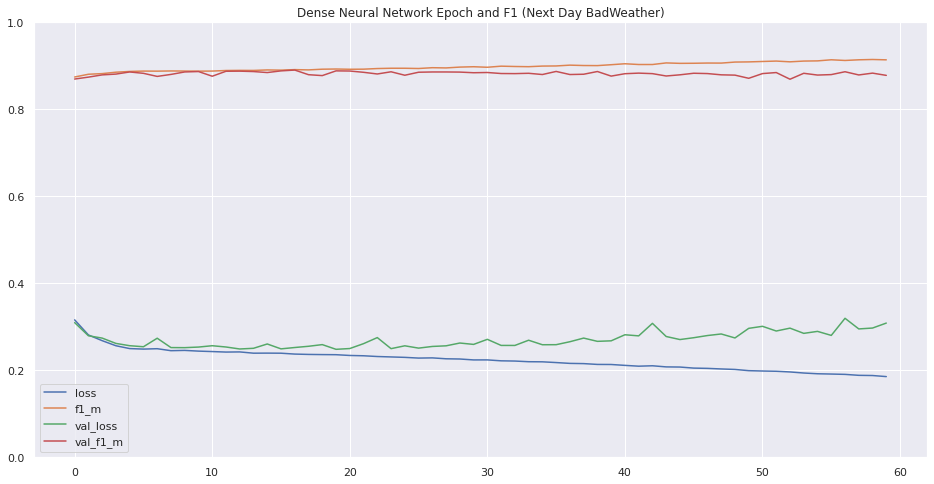

In [ ]:
#epoch and AUC


# model =  Sequential()
# model.add(Dense(300, input_dim=34, activation='relu'))
# model.add(Dense(200, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
model = createModel()
X_train, X_test, Y_train, Y_test = train_test_split(nextRainData,nexRainPredict_encode, \
                                                  test_size=0.1, random_state=150, shuffle = True)


history = model.fit(X_train,  Y_train, epochs= 60, validation_data= (X_test,Y_test ))

pd.DataFrame(history.history).plot(figsize= (16,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Dense Neural Network Epoch and F1 (Next Day BadWeather)")
plt.show()

In [ ]:
#tweak learning rate
def neuronsLayer(value, input):

  # epochs=50
  # learning_rate = learning
  # decay_rate = learning_rate / epochs
  # momentum = 0.8

  # sgd = SGD(lr=learning_rate,  decay=decay_rate, momentum = momentum nesterov=False)
  model =  Sequential()
  model.add(Dense(value, input_dim=input, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(round(value*2/3), activation='relu'))
  model.add(Dense(2, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
  
  return model 

#

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict_encode, test_size=0.1, shuffle = True)

In [ ]:
# model2 =  Sequential()
# model2.add(Dense(100, input_dim=35, activation='relu'))
# # model.add(Dropout(0.1))
# model2.add(Dense(100, activation='relu'))
# model2.add(Dense(round(10*2/3), activation='relu'))
# model2.add(Dense(2, activation='sigmoid'))
# model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
# model2.fit(X_train, y_train, epochs=50, batch_size=64,  verbose=0)
# y_pred = model2.predict(X_test)
# y_pred = np.argmax(y_pred, axis = 1)
# Y_test = np.argmax(y_test, axis = 1)
# f1_val = f1_score(Y_test, y_pred, average='macro')



In [ ]:
# sum(y_pred_v.round())
y_train.shape

(26564, 2)

(0.6840484895891975, 0.6907188361553267, 10)
(0.6830864650727057, 0.7089729604658784, 30)
(0.6810640950563154, 0.7179809277037851, 60)
(0.6881636624882779, 0.7173945205759061, 80)
(0.7044078838181842, 0.7292170236584485, 90)
(0.6987571578237346, 0.734073246501276, 100)
(0.6965545670993081, 0.740119647651797, 120)
(0.7047803504980349, 0.7362909570986861, 140)
(0.6891222684341312, 0.7263307545057478, 160)
(0.7128561536758294, 0.7444419949774115, 180)
(0.7058834727478862, 0.7495105305924251, 190)
(0.6957141340290629, 0.7286140735566036, 200)
(0.6887224072018745, 0.7225583274528888, 210)
(0.6919739768621488, 0.7345247451138943, 240)
(0.6861553105235695, 0.7336289574659938, 300)
(0.7010471219489386, 0.7379925410140074, 400)
sds


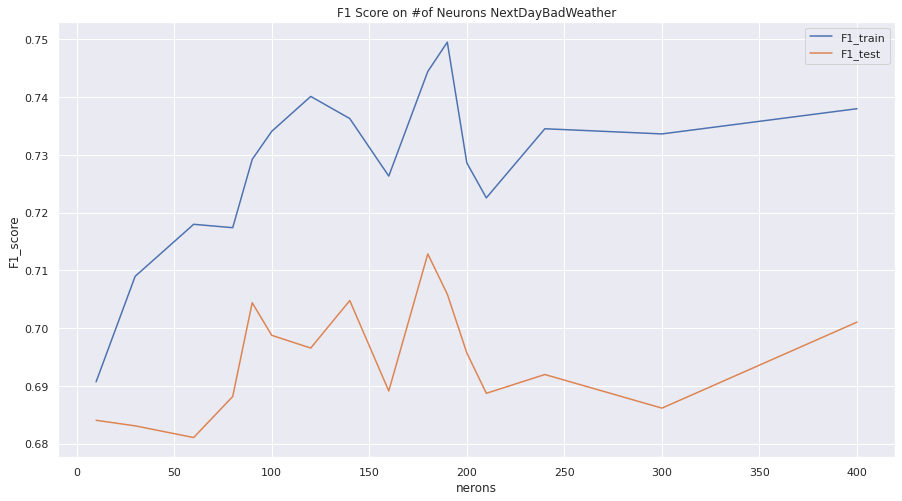

In [ ]:
def neuronGraph(neuronsLayer, X, Y):
  neurons = [10, 30, 60, 80, 90, 100, 120, 140, 160, 180, 190, 200, 210, 240, 300, 400]
  auclist = []
  X_train, X_test, y_train, y_test = train_test_split(X, Y, \
                                              test_size=0.1,  shuffle = True)
  for neu in neurons:
    model = neuronsLayer(neu, 35)
    model.fit(X_train, y_train, epochs=25, batch_size=64,  verbose=0)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1)
    y_train_pred = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred, axis = 1)

    y_test_lab = np.argmax(y_test, axis = 1)
    y_train_lab = np.argmax(y_train, axis = 1)

    f1_val_ne = f1_score(y_test_lab, y_pred, average='macro')
    train_auc_val = f1_score(y_train_lab, y_train_pred, average = 'macro')
    auclist.append((f1_val_ne,train_auc_val))
    print((f1_val_ne,train_auc_val, neu))

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
  'F1_test':pd.Series(list(zip(*auclist))[0]),
  'nerons':pd.Series(neurons)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on #of Neurons NextDayBadWeather")
  plt.plot('nerons','F1_train', data=d, label='F1_train')
  plt.plot('nerons','F1_test', data=d, label='F1_test')
  plt.xlabel('nerons')
  plt.ylabel('F1_score')
  # plt.ylim([0.6,1.1])
  plt.legend()

neuronGraph(neuronsLayer, X_train, y_train)

### Tweak the learnng rate

In [47]:
# opt = keras.optimizers.Adam(learning_rate=10e-05)
#tweak learning rate
def learningRate(learning, input):

  # epochs=50
  # learning_rate = learning
  # decay_rate = learning_rate / epochs
  # momentum = 0.8

  # sgd = SGD(lr=learning_rate,  decay=decay_rate, momentum = momentum nesterov=False)
  opt = keras.optimizers.Adam(learning_rate=learning)
  model =  Sequential()
  model.add(Dense(180, input_dim=input, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(round(180*2/3), activation='relu'))
  model.add(Dense(2, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m])
  
  return model 

In [ ]:
import math

# math.log(10)
learning = 10e-05
learningLst = []
learningLst.append(learning)
for i in range (0,42):
  learning  = 1.2 * learning
  learningLst.append(learning)



In [ ]:
# learningLst = [0.001, 0.01, 1.0]
X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict_encode, test_size=0.1, random_state=150, shuffle = True)

In [ ]:
# learningLst

(0.6925457260171706, 0.6949601321352179, 0.0001)
(0.7002824399612362, 0.6998111621175978, 0.00012)
(0.6942106259924538, 0.7040234600971145, 0.000144)
(0.6944437577853705, 0.7188918484316893, 0.0001728)
(0.710895418947952, 0.7263493192820052, 0.00020736)
(0.7136160805175581, 0.7305814851195287, 0.000248832)
(0.7113467221729834, 0.7412144857075535, 0.0002985984)
(0.7261477556002294, 0.7440225623004322, 0.00035831808)
(0.7261761127700863, 0.7511557272215504, 0.000429981696)
(0.7300045329312839, 0.7507956510843699, 0.0005159780352)
(0.7290191683832499, 0.7566167274787357, 0.00061917364224)
(0.7349169206210999, 0.7596598835810844, 0.000743008370688)
(0.7388916152723046, 0.7558259098318001, 0.0008916100448256)
(0.734727215503413, 0.7559846369977343, 0.00106993205379072)
(0.7288440749802823, 0.7524505922686061, 0.0012839184645488638)
(0.7344622913697467, 0.7525786440278645, 0.0015407021574586365)
(0.7157680787334189, 0.7437541846587641, 0.0018488425889503638)
(0.7366245011767114, 0.7457756888

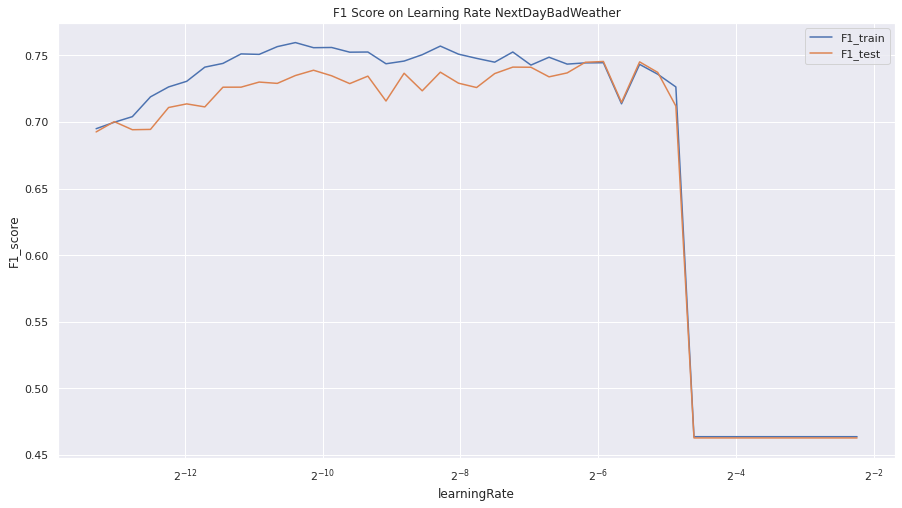

In [ ]:

def findLearning(learningLst, learningRate, X, Y, input ):
  auclist = []
  X_train, X_test, y_train, y_test = train_test_split(X, Y, \
                                              test_size=0.1,  random_state=150, shuffle = True)
  for learn in learningLst:
    model = learningRate(learn, input)
    model.fit(X_train, y_train, epochs=25, batch_size=64,  verbose=0)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1)
    y_train_pred = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred, axis = 1)

    y_test_lab = np.argmax(y_test, axis = 1)
    y_train_lab = np.argmax(y_train, axis = 1)

    f1_val_ne = f1_score(y_test_lab, y_pred, average='macro')
    train_auc_val = f1_score(y_train_lab, y_train_pred, average = 'macro')
    auclist.append((f1_val_ne,train_auc_val))
    print((f1_val_ne,train_auc_val, learn))

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
  'F1_test':pd.Series(list(zip(*auclist))[0]),
  'learningRate':pd.Series(learningLst)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on Learning Rate NextDayBadWeather")
  plt.plot('learningRate','F1_train', data=d, label='F1_train')
  plt.plot('learningRate','F1_test', data=d, label='F1_test')
  plt.xlabel('learningRate')
  plt.ylabel('F1_score')
  plt.xscale('log', basex=2)
  # plt.xlim([10e-05, 1.1])
  # plt.ylim([0.6,1.1])
  plt.legend()
  return d

d = findLearning(learningLst, learningRate, X_train, y_train, 35 )

In [ ]:
#optimal learning rate 0.01648446623609512


### Fine tuning number of layers

In [50]:
def layersModel(hidden, input):

  # epochs=50
  # learning_rate = learning
  # decay_rate = learning_rate / epochs
  # momentum = 0.8

  # sgd = SGD(lr=learning_rate,  decay=decay_rate, momentum = momentum nesterov=False)
  opt = keras.optimizers.Adam(learning_rate=0.01648446623609512)
  model =  Sequential()
  model.add(Dense(180, input_dim=input, activation='relu'))
  model.add(Dropout(0.1))
  neur = 180
  drop = 0.1
  if hidden >1:
    for layer in range(hidden-1):
      neur = round(180*2/3)
      model.add(Dense(neur, activation = 'relu'))
      model.add(Dropout(0.1))
  else:
      model.add(Dense(180*2/3, activation = 'relu'))
      model.add(Dropout(0.1))
  model.add(Dense(2, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m])
  
  return model 

In [ ]:
hiddenval = [1,2,3,5,6,7]
# hiddenval = [1,2,3]

X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict_encode, test_size=0.1,  random_state=150, shuffle = True)

In [ ]:

def hiddenLayers(hiddenNumbers, layersModel, X, Y, input ):
  auclist = []
  X_train, X_test, y_train, y_test = train_test_split(X, Y, \
                                              test_size=0.1,  random_state=150, shuffle = True)
  for hidden in hiddenNumbers:
    model = layersModel(hidden, input)
    model.fit(X_train, y_train, epochs=50, batch_size=64,  verbose=0)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1)
    y_train_pred = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred, axis = 1)

    y_test_lab = np.argmax(y_test, axis = 1)
    y_train_lab = np.argmax(y_train, axis = 1)

    f1_val_ne = f1_score(y_test_lab, y_pred, average='macro')
    train_auc_val = f1_score(y_train_lab, y_train_pred, average = 'macro')
    auclist.append((f1_val_ne,train_auc_val))
    print((f1_val_ne,train_auc_val, hidden))

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
  'F1_test':pd.Series(list(zip(*auclist))[0]),
  'HiddenLayers':pd.Series(hiddenNumbers)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on # of hidden layers NextDayBadWeather")
  plt.plot('HiddenLayers','F1_train', data=d, label='F1_train')
  plt.plot('HiddenLayers','F1_test', data=d, label='F1_test')
  plt.xlabel('HiddenLayers')
  plt.ylabel('F1_score')
  # plt.xscale('log', basex=2)
  # plt.xlim([10e-05, 1.1])
  # plt.ylim([0.6,1.1])
  plt.legend()
  return d

d = hiddenLayers(hiddenval,layersModel, X_train, y_train, 35 )

In [54]:
def finalModel():
  final = learningRate(0.01648446623609512,35)
  # final = layersModel(2, 35)
  return final
X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict_encode, test_size=0.1, random_state = 150,  shuffle = True)
# learningCurveDT(X_train, y_train, finalModel)

In [55]:
##test score on final model
model = finalModel()
start = timer()
model.fit(X_train, y_train, epochs=50, batch_size=64,  verbose=0)
end = timer()
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_train_pred = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred, axis = 1)

Y_test = np.argmax(y_test, axis = 1)
Y_train = np.argmax(y_train, axis = 1)
f1_val = f1_score(Y_test, y_pred, average='macro')
train_auc = f1_score(Y_train, y_train_pred, average = 'macro')
# f1_val, train_auc = get_acc_NN_randomisedCV(X,Y, create_model,test_range)
print(f1_val, train_auc, start- end)

0.6482583040193188 0.6427053039629523 -32.460300280999945


## Bad Loan

In [56]:
defaultRun = defaultRun.fillna(0.0)
encoder = LabelEncoder()
encoder.fit(defaultPred)
defaultPred_encode = encoder.transform(defaultPred)
defaultPred_encode = to_categorical(defaultPred_encode)
X_train, X_test, y_train, y_test = train_test_split(defaultRun, defaultPred_encode, test_size=0.1, random_state=150, shuffle = True)

In [57]:
X_train.shape

(27000, 33)

In [ ]:
def createModel():
  model =  Sequential()
  model.add(Dense(300, input_dim=33, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=150)))
  model.add(Dense(200, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=150)))
  model.add(Dense(2, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

  return model 

createModel()

In [ ]:
# model = createModel()
# history = model.fit(X_train,  y_train, epochs= 60, validation_data= (X_test,y_test ))

# pd.DataFrame(history.history).plot(figsize= (16,8))
# plt.grid(True)
# plt.gca().set_ylim(0,1)
# plt.title("Dense Neural Network Epoch and F1 (Bad Loan)")
# plt.show()

0.005
(0.7022582331191976, 0.6988895196295777)
0.02
(0.6966436441342608, 0.6924098593477137)
0.03
(0.6968903110141363, 0.6606368070924448)
0.05
(0.6999921317974942, 0.6815628977824161)
0.1
(0.7016398764881941, 0.6895856807541098)
0.15000000000000002
(0.7014343185254973, 0.6820769226777685)
0.2
(0.7031278297190672, 0.6772105745848059)
0.25
(0.7046416490538977, 0.6775439560232199)
0.3
(0.6935210778357723, 0.6696892462392827)
0.35000000000000003
(0.7001622145147671, 0.6712379892306374)
0.4
(0.6989574399670478, 0.677329271334913)
0.45
(0.705677447412523, 0.6821725954394324)
0.5
(0.6957035486454236, 0.6734710084280613)
0.55
(0.700307197733327, 0.6721273316145281)
0.6000000000000001
(0.7014279506978176, 0.671764211573406)
0.6500000000000001
(0.701015658807312, 0.6772389395551471)
0.7000000000000001
(0.7113701342465217, 0.684056029554733)
0.7500000000000001
(0.7022489939123656, 0.6748499370619753)
0.8
(0.7078363764848823, 0.6710862746373352)
0.8500000000000001
(0.7170824408119547, 0.678290655

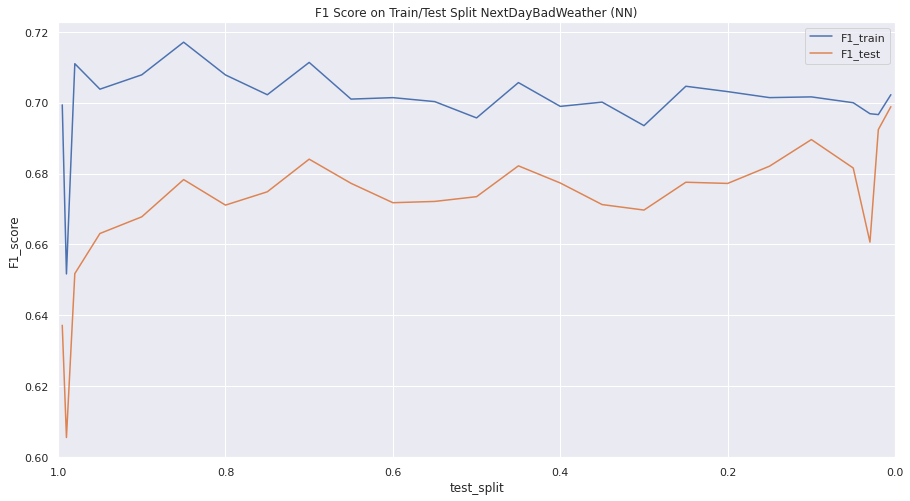

In [ ]:
learningCurveDT(X_train, y_train, createModel)

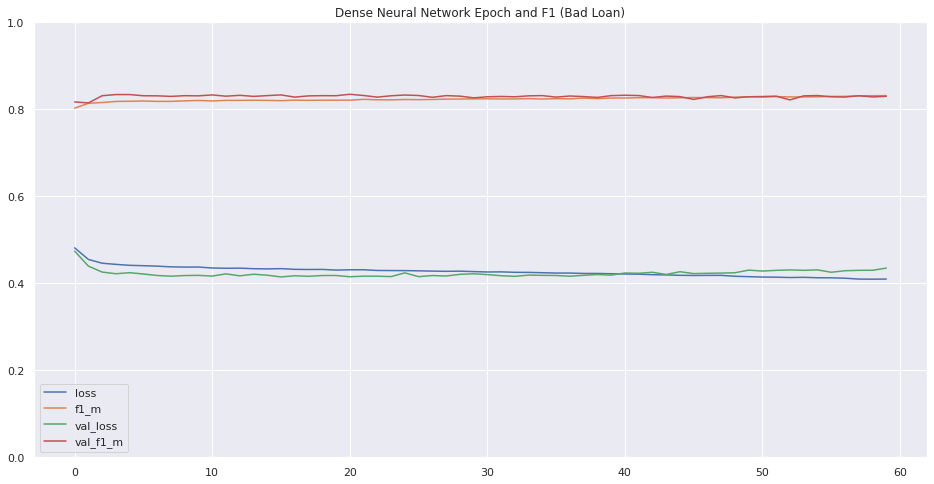

In [ ]:
model = createModel()


X_train, X_test, y_train, y_test = train_test_split(defaultRun, defaultPred_encode, test_size=0.1, random_state=150, shuffle = True)
history = model.fit(X_train,  y_train, epochs= 60, validation_data= (X_test,y_test ), verbose  = 0 )

pd.DataFrame(history.history).plot(figsize= (16,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Dense Neural Network Epoch and F1 (Bad Loan)")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(defaultRun, defaultPred_encode, test_size=0.1, random_state=150, shuffle = True)

## Tweak Learning Rate

In [ ]:
# opt = keras.optimizers.Adam(learning_rate=10e-05)
#tweak learning rate
def learningRate(learning, input):

  # epochs=50
  # learning_rate = learning
  # decay_rate = learning_rate / epochs
  # momentum = 0.8

  # sgd = SGD(lr=learning_rate,  decay=decay_rate, momentum = momentum nesterov=False)
  opt = keras.optimizers.Adam(learning_rate=learning)
  model =  Sequential()
  model.add(Dense(300, input_dim=input, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=150)))
  model.add(Dropout(0.1))
  model.add(Dense(200, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=150)))
  model.add(Dense(2, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m])
  
  return model 
import math

# math.log(10)
learning = 10e-05
learningLst = []
learningLst.append(learning)
for i in range (0,42):
  learning  = 1.2 * learning
  learningLst.append(learning)


In [58]:
def findLearning(learningLst, learningRate, X, Y, input ):
  auclist = []
  X_train, X_test, y_train, y_test = train_test_split(X, Y, \
                                              test_size=0.1,  random_state=150, shuffle = True)
  for learn in learningLst:
    model = learningRate(learn, input)
    model.fit(X_train, y_train, epochs=25, batch_size=64,  verbose=0)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1)
    y_train_pred = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred, axis = 1)

    y_test_lab = np.argmax(y_test, axis = 1)
    y_train_lab = np.argmax(y_train, axis = 1)

    f1_val_ne = f1_score(y_test_lab, y_pred, average='macro')
    train_auc_val = f1_score(y_train_lab, y_train_pred, average = 'macro')
    auclist.append((f1_val_ne,train_auc_val))
    print((f1_val_ne,train_auc_val, learn))

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
  'F1_test':pd.Series(list(zip(*auclist))[0]),
  'learningRate':pd.Series(learningLst)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on Learning Rate BadLoan")
  plt.plot('learningRate','F1_train', data=d, label='F1_train')
  plt.plot('learningRate','F1_test', data=d, label='F1_test')
  plt.xlabel('learningRate')
  plt.ylabel('F1_score')
  plt.xscale('log', basex=2)
  # plt.xlim([10e-05, 1.1])
  # plt.ylim([0.6,1.1])
  plt.legend()
  return d

d = findLearning(learningLst, learningRate, X_train, y_train, 33 )

## number of Neurons

In [59]:
def neuronsLayer(value, input):

  # epochs=50
  # learning_rate = learning
  # decay_rate = learning_rate / epochs
  # momentum = 0.8
  opt = keras.optimizers.Adam(learning_rate=0.01978135948331414)
  # sgd = SGD(lr=learning_rate,  decay=decay_rate, momentum = momentum nesterov=False)
  model =  Sequential()
  model.add(Dense(value, input_dim=input, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=150)))
  model.add(Dropout(0.1))
  model.add(Dense(round(value*2/3), activation='relu', kernel_initializer=initializers.glorot_uniform(seed=150)))
  model.add(Dense(2, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m])
  
  return model 



In [61]:
def neuronGraph(neuronsLayer, X, Y):
  neurons = [10, 30, 60, 80, 90, 100, 120, 140, 160, 180, 190, 200, 210, 240, 300, 400]
  auclist = []
  X_train, X_test, y_train, y_test = train_test_split(X, Y, \
                                              test_size=0.1,  shuffle = True)
  for neu in neurons:
    model = neuronsLayer(neu, 33)
    model.fit(X_train, y_train, epochs=40, batch_size=64,  verbose=0)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1)
    y_train_pred = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred, axis = 1)

    y_test_lab = np.argmax(y_test, axis = 1)
    y_train_lab = np.argmax(y_train, axis = 1)

    f1_val_ne = f1_score(y_test_lab, y_pred, average='macro')
    train_auc_val = f1_score(y_train_lab, y_train_pred, average = 'macro')
    auclist.append((f1_val_ne,train_auc_val))
    print((f1_val_ne,train_auc_val, neu))

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
  'F1_test':pd.Series(list(zip(*auclist))[0]),
  'nerons':pd.Series(neurons)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on #of Neurons BadLoan")
  plt.plot('nerons','F1_train', data=d, label='F1_train')
  plt.plot('nerons','F1_test', data=d, label='F1_test')
  plt.xlabel('nerons')
  plt.ylabel('F1_score')
  # plt.ylim([0.6,1.1])
  plt.legend()

neuronGraph(neuronsLayer, X_train, y_train)

## Tweak the number of layers


In [62]:
def layersModel(hidden, input):

  # epochs=50
  # learning_rate = learning
  # decay_rate = learning_rate / epochs
  # momentum = 0.8

  # sgd = SGD(lr=learning_rate,  decay=decay_rate, momentum = momentum nesterov=False)
  opt = keras.optimizers.Adam(learning_rate=0.01978135948331414)
  model =  Sequential()
  model.add(Dense(160, input_dim=input, activation='relu'))
  model.add(Dropout(0.1))
  neur = 160
  drop = 0.1
  if hidden >1:
    for layer in range(hidden-1):
      neur = round(neur*2/3)
      model.add(Dense(neur, activation = 'relu', kernel_initializer=initializers.glorot_uniform(seed=150)))
      if neur >=20:
        model.add(Dropout(0.1))
  else:
      model.add(Dense(160*2/3, activation = 'relu', kernel_initializer=initializers.glorot_uniform(seed=150)))
      model.add(Dropout(0.1))
  model.add(Dense(2, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m])
  
  return model 

In [63]:
hiddenval = [1,2,3,5,6,7]

In [64]:

def hiddenLayers(hiddenNumbers, layersModel, X, Y, input ):
  auclist = []
  X_train, X_test, y_train, y_test = train_test_split(X, Y, \
                                              test_size=0.1,  random_state=150, shuffle = True)
  for hidden in hiddenNumbers:
    model = layersModel(hidden, input)
    model.fit(X_train, y_train, epochs=50, batch_size=64,  verbose=0)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1)
    y_train_pred = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred, axis = 1)

    y_test_lab = np.argmax(y_test, axis = 1)
    y_train_lab = np.argmax(y_train, axis = 1)

    f1_val_ne = f1_score(y_test_lab, y_pred, average='macro')
    train_auc_val = f1_score(y_train_lab, y_train_pred, average = 'macro')
    auclist.append((f1_val_ne,train_auc_val))
    print((f1_val_ne,train_auc_val, hidden))

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
  'F1_test':pd.Series(list(zip(*auclist))[0]),
  'HiddenLayers':pd.Series(hiddenNumbers)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on # of hidden layers BadLoan")
  plt.plot('HiddenLayers','F1_train', data=d, label='F1_train')
  plt.plot('HiddenLayers','F1_test', data=d, label='F1_test')
  plt.xlabel('HiddenLayers')
  plt.ylabel('F1_score')
  # plt.xscale('log', basex=2)
  # plt.xlim([10e-05, 1.1])
  # plt.ylim([0.6,1.1])
  plt.legend()
  return d
d = hiddenLayers(hiddenval,layersModel, X_train, y_train, 33 )

KeyboardInterrupt: ignored

In [ ]:
def learningCurveDT(X,Y, create_model):
  testPercent = np.arange(0.05, 1.0, 0.05)
  testPercent = np.concatenate(( np.asarray([0.005, 0.02, 0.03]), testPercent, np.asarray([0.98,0.99, 0.995])))
  # testPercent = [0.85]
  auclist = []
  for test_range in testPercent:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, \
                                                  test_size=test_range, random_state = 150, shuffle = True)
    model = create_model()
    model.fit(X_train, Y_train, epochs=50, batch_size=64,  verbose=0)
    print(test_range)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1)
    y_train_pred = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred, axis = 1)


    Y_test = np.argmax(Y_test, axis = 1)
    Y_train = np.argmax(Y_train, axis = 1)
    f1_val = f1_score(Y_test, y_pred, average='macro')
    train_auc = f1_score(Y_train, y_train_pred, average = 'macro')
    f1_val, train_auc = get_acc_NN_randomisedCV(X,Y, create_model,test_range)
    auclist.append((f1_val,train_auc))
    # auc = get_acc_NN_randomisedCV(X,Y,model, test_range)
    # auclist.append(auc)
    print((train_auc,f1_val))
  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
    'F1_test':pd.Series(list(zip(*auclist))[0]),
  'test_split':pd.Series(testPercent)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on Train/Test Split BadLoans (NN)")
  plt.plot('test_split','F1_train', data=d, label='F1_train')
  plt.plot('test_split','F1_test', data=d, label='F1_test')
  plt.xlabel('test_split')
  plt.xlim([1.0,0.0])
  plt.ylabel('F1_score')
  # plt.ylim([0.6,0.8])
  plt.legend()

In [65]:
def finalModel():
  # final = learningRate(0.01648446623609512,35)
  final = layersModel(3, 33)
  return final
# X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict_encode, test_size=0.1, random_state = 150,  shuffle = True)
# learningCurveDT(X_train, y_train, finalModel)

In [66]:
##test score on final model
model = finalModel()
start = timer()
model.fit(X_train, y_train, epochs=50, batch_size=64,  verbose=0)
end = timer()
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_train_pred = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred, axis = 1)

Y_test = np.argmax(y_test, axis = 1)
Y_train = np.argmax(y_train, axis = 1)
f1_val = f1_score(Y_test, y_pred, average='macro')
train_auc = f1_score(Y_train, y_train_pred, average = 'macro')
# f1_val, train_auc = get_acc_NN_randomisedCV(X,Y, create_model,test_range)
print(f1_val, train_auc, end - start)

0.695928799641673 0.6997125059814537 44.811739619000036


# Adaboost


## Grid Search Weather

In [69]:
nextRainData = nextRainData.fillna(0.0)
X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict, test_size=0.1, random_state=150, shuffle = True)

In [ ]:
def run_randomGridAB(X_train, Y_train):
  tuner = dict()
  tuner['n_estimators'] = [10, 50, 100, 500]
  tuner['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
  # path=DecisionTreeClassifier(criterion='gini',random_state=1).cost_complexity_pruning_path(X_train, Y_train)
  # ccp_alphas, impurities = path.ccp_alphas, path.impurities
  # if len(ccp_alphas)<100:
  #   ccp_alphas_sub = ccp_alphas
  # else:
  #   ccp_alphas_sub = ccp_alphas[1::50]
  # tuner['ccp_alpha'] = ccp_alphas_sub
  # base = DecisionTreeClassifier()
  model = AdaBoostClassifier()
  search = RandomizedSearchCV(model, tuner, n_iter=200, scoring='f1', n_jobs=-1, random_state=1)
  search = search.fit(X_train,Y_train)
  return search

In [ ]:
search = run_randomGridAB(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 20 is smaller than n_iter=200. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [ ]:
print(search.best_params_)
print(search.best_estimator_.score)
print(search.best_score_)

{'n_estimators': 500, 'learning_rate': 1.0}
<bound method ClassifierMixin.score of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=500, random_state=None)>
0.469515448508483


### Learning and training

In [ ]:
model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=500, random_state=None)

def get_acc_auc_randomisedCV(X,Y,model, test_percent, iterNo=5 ):
    rs = ShuffleSplit(n_splits=5, test_size=test_percent)
    auclist = []
    train_auc_lst = []
    for train_index, test_index in rs.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        f1_val = f1_score(y_test, y_pred, average='macro')
        auclist.append(f1_val)    
        train_auc = f1_score(y_train, y_train_pred, average = 'macro')
        train_auc_lst.append(train_auc) 

        
    return (statistics.mean(auclist), statistics.mean(train_auc_lst))


In [77]:
def learningCurveAB(X,Y, model):
  testPercent = np.arange(0.05, 1.0, 0.05)
  testPercent = np.concatenate(( np.asarray([0.02, 0.03]), testPercent, np.asarray([0.98,0.99, 0.995])))
  auclist = []
  for test_range in testPercent:
    auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=test_range)
    auclist.append(auc)
    print(auc)
  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
    'F1_test':pd.Series(list(zip(*auclist))[0]),
  'test_split':pd.Series(testPercent)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on Train/Test Split NextDayBadWeather AdaBoost")
  plt.plot('test_split','F1_train', data=d, label='F1_train')
  plt.plot('test_split','F1_test', data=d, label='F1_test')
  plt.xlabel('test_split')
  plt.xlim([1.0,0.0])
  plt.ylabel('F1_score')
  # plt.ylim([0.6,0.8])
  plt.legend()
  return d 

# d = learningCurveAB(X_train,y_train, model)

### Experiment depth


In [ ]:
def depthTree(X,Y):
    max_depth = []
    acc_gini = []
    acc_entropy = []
    counter = 0
    ccp_alpha_sub = list(range(1,33))
    # ccp_alphas_sub = ccp_alphas[1::14]
    # ccp_alphas_sub = ccp_alphas_sub[:2]
    for i in ccp_alpha_sub:
        DT = DecisionTreeClassifier(max_depth = i, class_weight=None,
                            criterion='entropy')
        model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DT, learning_rate=1.0,
                        n_estimators=500, random_state=None) 
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=150, shuffle = True)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        f1_val = f1_score(y_test, y_pred, average='macro')
        train_auc = f1_score(y_train, y_train_pred, average = 'macro')
        # auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.5)
        acc_entropy.append((f1_val, train_auc))
        counter +=1
        print(counter, (f1_val, train_auc), i)

    d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
    'MaxDepth':pd.Series(ccp_alpha_sub)})
#     print("max alphas index")
#     print(np.argmax(np.asarray(list(zip(*acc_entropy))[0])))
#     print(ccp_alphas_sub[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
#     print(acc_entropy[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
    plt.figure(figsize=(15,8))
    plt.title("F1 Score on MaxDepth NextDayBadWeather")
    plt.plot('MaxDepth','F1_train', data=d, label='F1_train')
    plt.plot('MaxDepth','F1_test', data=d, label='F1_test')
    plt.xlabel('MaxDepth')
    plt.ylabel('F1_score')
    # plt.ylim([0.6,1.1])
    plt.legend()
    return d

d = depthTree(X_train, y_train)

## Experiment with alphas

In [62]:
path=DecisionTreeClassifier(criterion='gini',random_state=150, max_depth = 4).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
  # if len(ccp_alphas)<100:
  #   ccp_alphas_sub = ccp_alphas
  # else:
# ccp_alphas_sub = ccp_alphas[1::10]
len(ccp_alphas)

16

In [ ]:
  # path=DecisionTreeClassifier(criterion='gini',random_state=1).cost_complexity_pruning_path(X_train, y_train)
  # ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
# remain = ccp_alphas[ccp_alphas >= 0.0004803184501036405]
# print(len(remain))

12


1 (0.6178432162440539, 0.999038115630044) 0.0
2 (0.6211124155487231, 0.999038343355761) 0.00011183612617304372
3 (0.6190172987973075, 0.9989308596942943) 0.00011596503335633765
4 (0.6140238762933026, 0.9990374314392716) 0.00018008875622481553
5 (0.6158958429435927, 0.9989308596942943) 0.00020872759689717288
6 (0.6460562917904605, 0.7830286133416282) 0.0002460001525203988
7 (0.622617268255931, 0.9989308596942943) 0.00026380022227915625
8 (0.614366247307539, 0.9987173356051802) 0.00030986738971967506
9 (0.656150288665338, 0.7533433146395311) 0.00043133005511773737
10 (0.6756935289720583, 0.7025942325800525) 0.0007033397902438607
11 (0.6776562202268602, 0.6972129178110932) 0.000807749995707055
12 (0.67828418230563, 0.6906155969515906) 0.0010442020575527483
13 (0.6806603258954305, 0.6889530222863556) 0.0015694768898136258
14 (0.6576163775504922, 0.6612586751934886) 0.0033021446281855382
15 (0.6765206200957473, 0.6806003302945296) 0.010722272636517288
16 (0.6803404232042083, 0.6876011347146

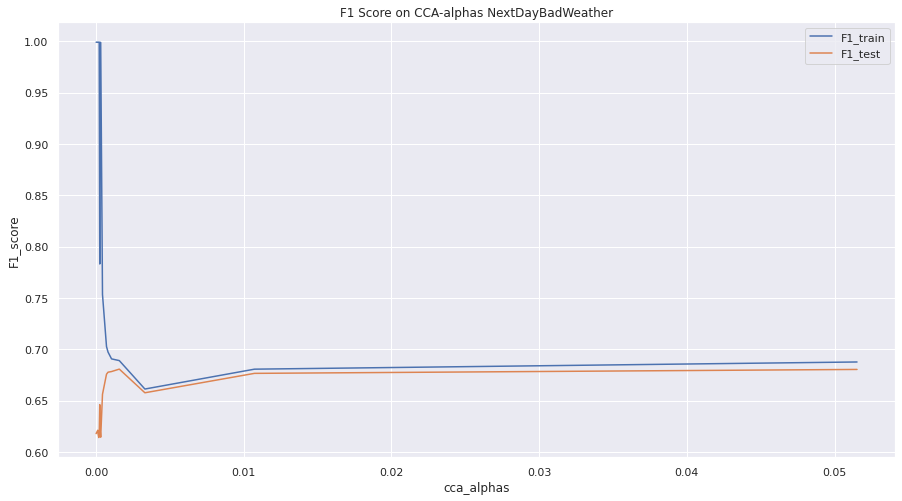

In [66]:
def alphaTuningAB(X,Y, ccp_alpha_sub):
  max_depth = []
  acc_gini = []
  acc_entropy = []
  counter = 0
  # ccp_alphas_sub = ccp_alphas[1::14]
  # ccp_alphas_sub = ccp_alphas_sub[:2]
  for i in ccp_alpha_sub:
    DT = DecisionTreeClassifier(ccp_alpha=i, class_weight=None, max_depth= 4,
                        criterion='entropy')
    model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DT, learning_rate=1.0,
                    n_estimators=500, random_state=None) 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=150, shuffle = True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    f1_val = f1_score(y_test, y_pred, average='macro')
    train_auc = f1_score(y_train, y_train_pred, average = 'macro')
    # auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.5)
    acc_entropy.append((f1_val, train_auc))
    counter +=1
    print(counter, (f1_val, train_auc), i)

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
  'cca_alphas':pd.Series(ccp_alpha_sub)})
  print("max alphas index")
  # print(np.argmax(np.asarray(list(zip(*acc_entropy))[0])))
  # print(ccp_alphas_sub[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  # print(acc_entropy[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on CCA-alphas NextDayBadWeather")
  plt.plot('cca_alphas','F1_train', data=d, label='F1_train')
  plt.plot('cca_alphas','F1_test', data=d, label='F1_test')
  plt.xlabel('cca_alphas')
  plt.ylabel('F1_score')
  # plt.ylim([0.6,1.1])
  plt.legend()
  return d

d = alphaTuningAB(X_train, y_train, ccp_alphas)

### Learning Rate

In [72]:
from numpy import arange

learning = 10e-05
learningLst = []
learningLst.append(learning)
for i in range (0,38):
  learning  = 1.3 * learning
  learningLst.append(learning)
len(learningLst)
# l = learningLst[:2]
max(learningLst)
learningLst = arange(0.01, 2.1, 0.05)

1 (0.679350263402893, 0.6832557660097982) 0.01
2 (0.6783620028601098, 0.6829304568138502) 0.060000000000000005
3 (0.6784000576231339, 0.6830277280858676) 0.11
4 (0.6801826457352039, 0.6837642046045596) 0.16000000000000003
5 (0.6792724309514062, 0.6831910976220591) 0.21000000000000002
6 (0.6756539155201693, 0.6831260757964669) 0.26
7 (0.6791216292589302, 0.6863491501901882) 0.31000000000000005
8 (0.6729355229838344, 0.6824623098081543) 0.36000000000000004
9 (0.6756762039172125, 0.6849780975431953) 0.41000000000000003
10 (0.6754626408930561, 0.6852311278675287) 0.46
11 (0.6789199191541637, 0.6850518349498103) 0.51
12 (0.6701318832582047, 0.680400510270722) 0.56
13 (0.6709353508710868, 0.6854633879114842) 0.6100000000000001
14 (0.6768422610816138, 0.6884817502094382) 0.66
15 (0.6787505490798939, 0.6883977402264573) 0.7100000000000001
16 (0.6772540198510744, 0.6852799802352075) 0.76
17 (0.6805319602731532, 0.6893980167147326) 0.81
18 (0.6770629573837527, 0.6883804502369848) 0.8600000000000

,F1_train,F1_test,learning_rate
0,0.683256,0.679350,0.01
1,0.682930,0.678362,0.06
2,0.683028,0.678400,0.11
3,0.683764,0.680183,0.16
4,0.683191,0.679272,0.21
5,0.683126,0.675654,0.26
6,0.686349,0.679122,0.31
7,0.682462,0.672936,0.36
8,0.684978,0.675676,0.41
9,0.685231,0.675463,0.46


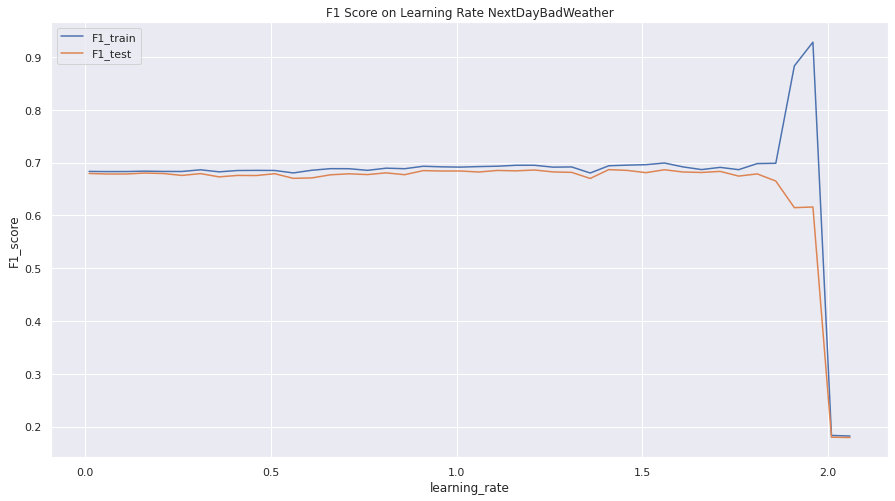

In [73]:
def learningRate(X,Y, learning):
  max_depth = []
  acc_gini = []
  acc_entropy = []
  counter = 0
  # ccp_alphas_sub = ccp_alphas[1::14]
  # ccp_alphas_sub = ccp_alphas_sub[:2]
  for i in learning:
    DT = DecisionTreeClassifier(ccp_alpha=0.0015694768898136258, class_weight=None, max_depth = 4,
                        criterion='entropy')
    model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DT, learning_rate=i,
                    n_estimators=500, random_state=None) 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=150, shuffle = True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    f1_val = f1_score(y_test, y_pred, average='macro')
    train_auc = f1_score(y_train, y_train_pred, average = 'macro')
    # auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.5)
    acc_entropy.append((f1_val, train_auc))
    counter +=1
    print(counter, (f1_val, train_auc), i)

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
  'learning_rate':pd.Series(learning)})
  print("max alphas index")
  print(np.argmax(np.asarray(list(zip(*acc_entropy))[0])))
  print(learning[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  print(acc_entropy[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on Learning Rate NextDayBadWeather")
  plt.plot('learning_rate','F1_train', data=d, label='F1_train')
  plt.plot('learning_rate','F1_test', data=d, label='F1_test')
  # plt.xscale('log', basex=2)
  plt.xlabel('learning_rate')
  plt.ylabel('F1_score')
  # plt.ylim([0.6,1.1])
  plt.legend()
  return d
learningRate(X_train, y_train, learningLst)

## Number of estimators


In [ ]:
estimators = [3, 5, 7 , 10, 50, 100, 500, 750]

1 (0.6827665651251265, 0.6886849890490667) 1
2 (0.6856180856180856, 0.6932226898660037) 3
3 (0.6866697439540874, 0.6939536440110311) 5
4 (0.6866697439540874, 0.6939536440110311) 7
5 (0.6866697439540874, 0.6939536440110311) 10
6 (0.6866697439540874, 0.6939536440110311) 50
7 (0.6866697439540874, 0.6939536440110311) 100
8 (0.6866697439540874, 0.6939536440110311) 250
9 (0.6866697439540874, 0.6939536440110311) 500
max alphas index
2
5
(0.6866697439540874, 0.6939536440110311)


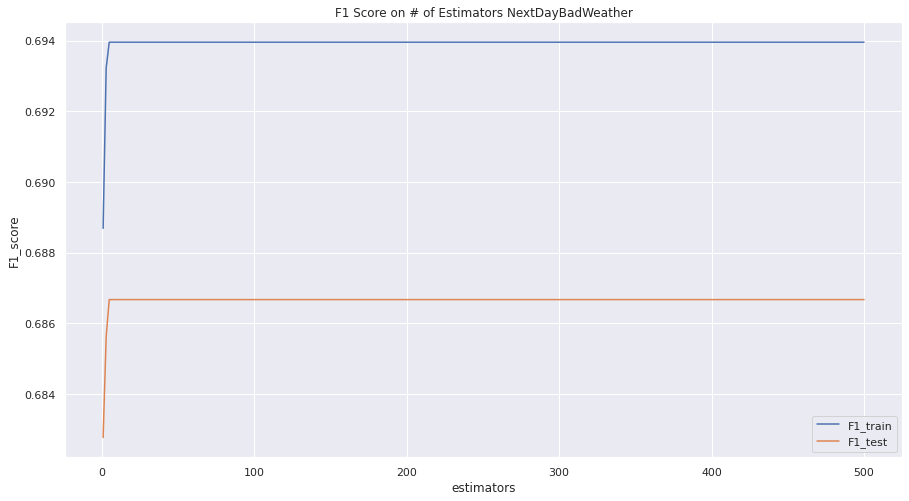

In [75]:
def estimatorADA(X,Y):
  max_depth = []
  acc_gini = []
  acc_entropy = []
  counter = 0
  estimatlst =  [1, 3, 5, 7, 10, 50, 100, 250, 500]

  # ccp_alphas_sub = ccp_alphas[1::14]
  # ccp_alphas_sub = ccp_alphas_sub[:2]
  for i in estimatlst:
    DT = DecisionTreeClassifier(ccp_alpha=0.0015694768898136258, class_weight=None, max_depth = 4,
                        criterion='entropy')
    model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DT, learning_rate=1.41,
                    n_estimators=i, random_state=None) 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=150, shuffle = True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    f1_val = f1_score(y_test, y_pred, average='macro')
    train_auc = f1_score(y_train, y_train_pred, average = 'macro')
    # auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.5)
    acc_entropy.append((f1_val, train_auc))
    counter +=1
    print(counter, (f1_val, train_auc), i)

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
  'estimators':pd.Series(estimatlst)})
  print("max alphas index")
  print(np.argmax(np.asarray(list(zip(*acc_entropy))[0])))
  print(estimatlst[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  print(acc_entropy[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on # of Estimators NextDayBadWeather")
  plt.plot('estimators','F1_train', data=d, label='F1_train')
  plt.plot('estimators','F1_test', data=d, label='F1_test')
  # plt.xscale('log', basex=2)
  plt.xlabel('estimators')
  plt.ylabel('F1_score')
  # plt.ylim([0.6,1.1])
  plt.legend()
  return d
d = estimatorADA(X_train, y_train)

In [ ]:
## Final Train test splpit

In [70]:
DT = DecisionTreeClassifier(ccp_alpha=0.0015694768898136258, class_weight=None, max_depth = 4,
                    criterion='entropy')
model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DT, learning_rate=1.41,
                n_estimators=5, random_state=None) 

# d = learningCurveAB(X_train,y_train, model)


In [71]:
##final model
start = timer()
model.fit(X_train,y_train)
end = timer()
y_pred = model.predict(X_test)

f1_val = f1_score(y_test, y_pred, average='macro')
print(f1_val, end - start)

0.6893279617043551 0.8604562440000336


## Bad Loan


### Grid Search **Badlaon**

In [72]:
X_train, X_test, y_train, y_test = train_test_split(defaultRun, defaultPred, test_size=0.1, random_state=1, shuffle = True)

In [ ]:
# search = run_randomGridAB(X_train, y_train)
print(search.best_params_)
print(search.best_estimator_.score)
print(search.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 20 is smaller than n_iter=200. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'n_estimators': 500, 'learning_rate': 0.1}
<bound method ClassifierMixin.score of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=500, random_state=None)>
0.4473580931416433


(0.6699021223365981, 0.670480002465716)
(0.6682907740303451, 0.6713720859561273)
(0.6621647635406376, 0.6713132813763629)
(0.6597826296429058, 0.6730148821158415)
(0.6708996798512988, 0.669366975132456)
(0.6659950329061822, 0.6719667708573851)
(0.6662000440149232, 0.6719815772504192)
(0.6666866205510178, 0.6694487269222608)
(0.664146797118484, 0.6740824022435931)
(0.6660416255408039, 0.673203202659646)
(0.6666030577669783, 0.6700002364248017)
(0.6645278401889747, 0.6737490629908629)
(0.6677370161471058, 0.6728633564949689)
(0.6676891902813539, 0.6699294347795236)
(0.6696348074815056, 0.6777367054141691)
(0.6648242225000818, 0.6764537455661608)
(0.6643734079583901, 0.6728788483127405)
(0.6665722577653924, 0.6793301107309989)
(0.662505290069372, 0.6814480713302572)
(0.6580023547025278, 0.6846487715836312)
(0.6631410318198069, 0.7170966093477649)
(0.6457547410737569, 0.7593025219686427)
(0.616801279414225, 0.8348702037325115)
(0.5819586566465917, 0.9751134400386806)
sds


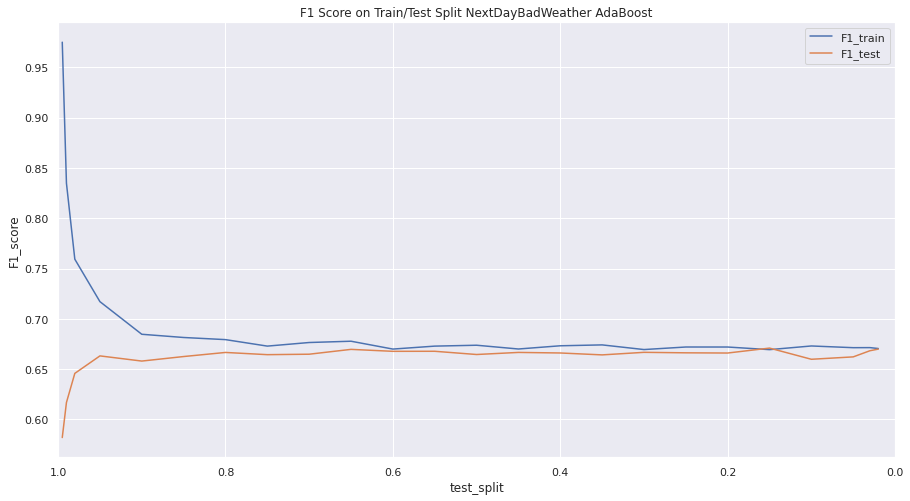

In [ ]:
model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=500, random_state=None)

d = learningCurveAB(X_train,y_train, model)

## MaxDepth

1 (0.6625971633027712, 0.6743946446475376) 1
2 (0.6699190506217706, 0.7078477608848064) 2
3 (0.6640157722407296, 0.7800294073008156) 3
4 (0.6485039450662524, 0.8687404319302308) 4
5 (0.6425709391445863, 0.982002948336271) 5
6 (0.6437122371748665, 0.9989306061964129) 6
7 (0.6499424524620976, 0.999038115630044) 7
8 (0.6544166296524089, 0.9990378877354988) 8
9 (0.644107224412626, 0.9990378877354988) 9
10 (0.637565840839966, 0.9990376596719627) 10
11 (0.6361737732471193, 0.9990378877354988) 11
12 (0.6379396851916228, 0.9990376596719627) 12
13 (0.6336929851954293, 0.9990374314392716) 13
14 (0.6370892732705777, 0.9990376596719627) 14
15 (0.6398727669523838, 0.9990378877354988) 15
16 (0.6562799866527494, 0.9990378877354988) 16
17 (0.6410139301210322, 0.9990376596719627) 17
18 (0.6470493543559221, 0.9990378877354988) 18
19 (0.6486776529702926, 0.9990372030372623) 19
20 (0.6576956449425774, 0.999038115630044) 20
21 (0.6576514048952273, 0.9990374314392716) 21
22 (0.6588359703989928, 0.9990378877

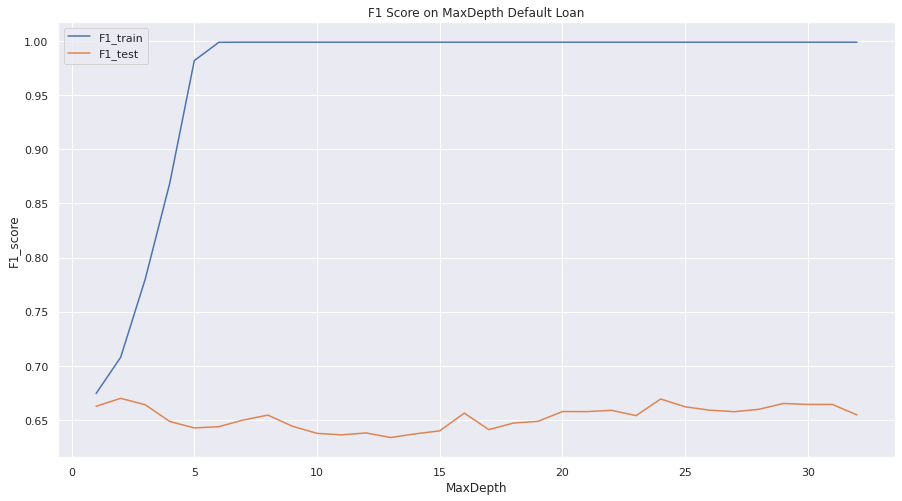

In [84]:
def depthTree(X,Y):
    max_depth = []
    acc_gini = []
    acc_entropy = []
    counter = 0
    ccp_alpha_sub = list(range(1,33))
    # ccp_alphas_sub = ccp_alphas[1::14]
    # ccp_alphas_sub = ccp_alphas_sub[:2]
    for i in ccp_alpha_sub:
        DT = DecisionTreeClassifier(max_depth = i, class_weight=None,
                            criterion='entropy')
        model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DT, learning_rate=0.1,
                        n_estimators=500, random_state=None) 
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=150, shuffle = True)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        f1_val = f1_score(y_test, y_pred, average='macro')
        train_auc = f1_score(y_train, y_train_pred, average = 'macro')
        # auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.5)
        acc_entropy.append((f1_val, train_auc))
        counter +=1
        print(counter, (f1_val, train_auc), i)

    d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
    'MaxDepth':pd.Series(ccp_alpha_sub)})
#     print("max alphas index")
#     print(np.argmax(np.asarray(list(zip(*acc_entropy))[0])))
#     print(ccp_alphas_sub[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
#     print(acc_entropy[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
    plt.figure(figsize=(15,8))
    plt.title("F1 Score on MaxDepth Default Loan")
    plt.plot('MaxDepth','F1_train', data=d, label='F1_train')
    plt.plot('MaxDepth','F1_test', data=d, label='F1_test')
    plt.xlabel('MaxDepth')
    plt.ylabel('F1_score')
    # plt.ylim([0.6,1.1])
    plt.legend()
    return d

d = depthTree(X_train, y_train)

### Number of Estimators

1 (0.6699190506217706, 0.7078477608848064) 3
2 (0.6699190506217706, 0.7078477608848064) 5
3 (0.6699190506217706, 0.7078477608848064) 7
4 (0.6699190506217706, 0.7078477608848064) 10
5 (0.6699190506217706, 0.7078477608848064) 50
6 (0.6699190506217706, 0.7078477608848064) 100
7 (0.6699190506217706, 0.7078477608848064) 250
8 (0.6699190506217706, 0.7078477608848064) 500
9 (0.6699190506217706, 0.7078477608848064) 750
10 (0.6699190506217706, 0.7078477608848064) 1000
max alphas index


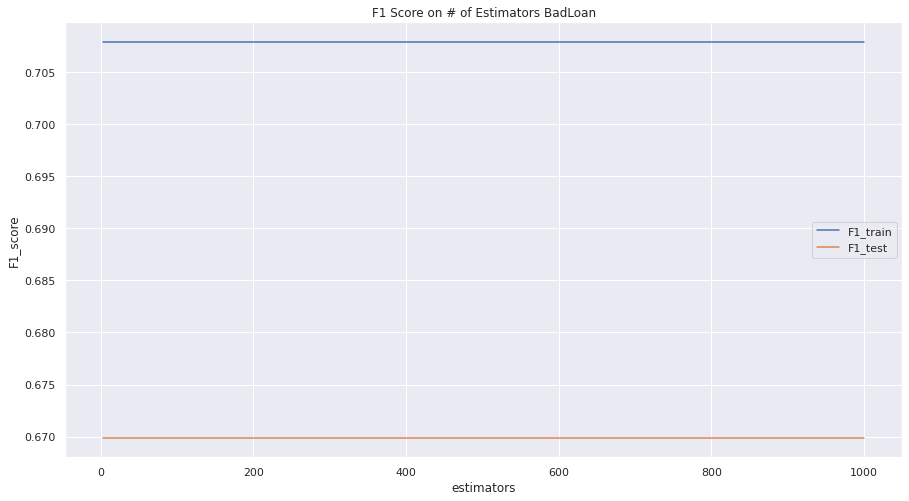

In [86]:
def estimatorADA(X,Y):
  max_depth = []
  acc_gini = []
  acc_entropy = []
  counter = 0
  estimatlst =  [3, 5, 7, 10, 50, 100, 250, 500, 750, 1000]

  # ccp_alphas_sub = ccp_alphas[1::14]
  # ccp_alphas_sub = ccp_alphas_sub[:2]
  for i in estimatlst:

    DT = DecisionTreeClassifier(max_depth = 2, class_weight=None,
                        criterion='entropy')
    model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DT, learning_rate=0.1,
                        n_estimators=500, random_state=None) 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=150, shuffle = True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    f1_val = f1_score(y_test, y_pred, average='macro')
    train_auc = f1_score(y_train, y_train_pred, average = 'macro')
    # auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.5)
    acc_entropy.append((f1_val, train_auc))
    counter +=1
    print(counter, (f1_val, train_auc), i)

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
  'estimators':pd.Series(estimatlst)})
  print("max alphas index")
  # print(np.argmax(np.asarray(list(zip(*acc_entropy))[0])))
  # print(estimatlst[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  # print(acc_entropy[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on # of Estimators BadLoan")
  plt.plot('estimators','F1_train', data=d, label='F1_train')
  plt.plot('estimators','F1_test', data=d, label='F1_test')
  # plt.xscale('log', basex=2)
  plt.xlabel('estimators')
  plt.ylabel('F1_score')
  # plt.ylim([0.6,1.1])
  plt.legend()
  return d
d = estimatorADA(X_train, y_train)

### Alpha Pruning

In [ ]:
path=DecisionTreeClassifier(criterion='gini',random_state=1, max_depth = 2).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas_sub = ccp_alphas[1::20]
# print(len(ccp_alphas_sub))

In [ ]:
def alphaTuningAB(X,Y, ccp_alpha_sub):
  max_depth = []
  acc_gini = []
  acc_entropy = []
  counter = 0
  # ccp_alphas_sub = ccp_alphas[1::14]
  # ccp_alphas_sub = ccp_alphas_sub[:2]
  for i in ccp_alpha_sub:
    DT = DecisionTreeClassifier(ccp_alpha=i, class_weight=None,
                        criterion='entropy')
    model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DT, learning_rate=0.1,
                    n_estimators=550, random_state=None) 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=150, shuffle = True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    f1_val = f1_score(y_test, y_pred, average='macro')
    train_auc = f1_score(y_train, y_train_pred, average = 'macro')
    # auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.5)
    acc_entropy.append((f1_val, train_auc))
    counter +=1
    print(counter, (f1_val, train_auc), i)

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
  'cca_alphas':pd.Series(ccp_alpha_sub)})
  print("max alphas index")
  print(np.argmax(np.asarray(list(zip(*acc_entropy))[0])))
  print(ccp_alpha_sub[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  print(acc_entropy[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on CCA-alphas BadLoan")
  plt.plot('cca_alphas','F1_train', data=d, label='F1_train')
  plt.plot('cca_alphas','F1_test', data=d, label='F1_test')
  plt.xlabel('cca_alphas')
  plt.ylabel('F1_score')
  # plt.ylim([0.6,1.1])
  plt.legend()
  return d

d = alphaTuningAB(X_train, y_train, ccp_alphas_sub)

1 (0.6459942723750391, 0.9990367457246315) 5.432098765432095e-06
2 (0.6485426304772292, 0.9990367457246315) 1.851851851851852e-05
3 (0.6456059059051339, 0.9990367457246315) 2.3515579071134635e-05
4 (0.6426231248989648, 0.9990367457246315) 2.506791468302e-05
5 (0.6422736051111461, 0.9990367457246315) 2.9629629629629623e-05
6 (0.6399001729877307, 0.9990367457246315) 3.174603174603175e-05
7 (0.6396762377412761, 0.9990367457246315) 3.240740740740741e-05
8 (0.6354031139580989, 0.9990367457246315) 3.295206971677564e-05
9 (0.6438594521778176, 0.9990367457246315) 3.364197530864199e-05
10 (0.639265374683579, 0.9990367457246315) 3.395061728395062e-05
11 (0.6371223804771841, 0.9990367457246315) 3.4391534391534404e-05
12 (0.6381271096322763, 0.9990367457246315) 3.472222222222222e-05
13 (0.6423793943253887, 0.9990367457246315) 3.497942386831276e-05
14 (0.640102305100761, 0.9990367457246315) 3.5185185185185176e-05
15 (0.639815589995233, 0.9990367457246315) 3.537866224433388e-05
16 (0.638880303783164

max alphas index


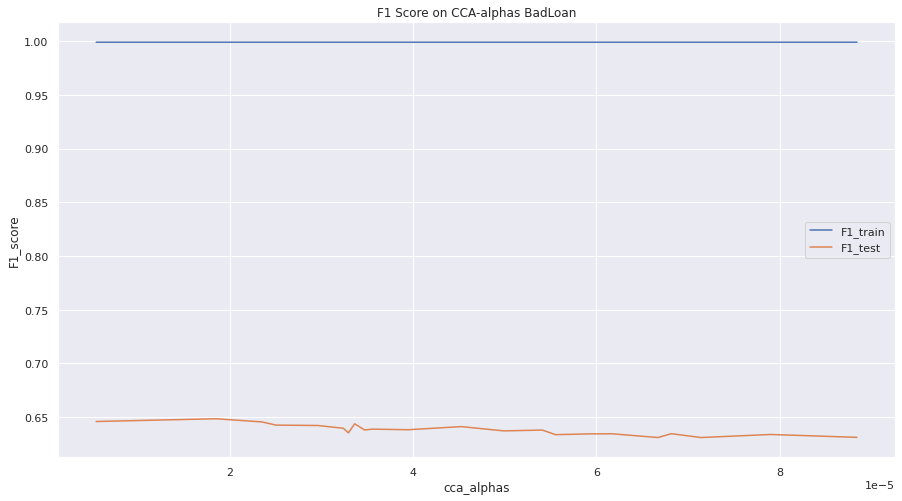

In [ ]:

valid = [0.6459942723750391, 0.6485426304772292, 0.6456059059051339, 0.6426231248989648, 0.6422736051111461, 0.6396762377412761, 0.635403113958098, 
         0.6438594521778176, 0.6381271096322763, 0.6388803037831643, 0.6383525547350101, 0.6412283896403456, 0.6372550457433088, 0.6380228267674801,
         0.6337407953199671, 0.634473393822478, 0.6345560674145166, 0.6310730329806391, 0.6346400045174845, 0.6310676453037151, 0.6339145715465145, 0.6312378614836354]
train = [0.9990367457246315, 0.9990367457246315, 0.9990367457246315,  0.9990367457246315, 0.9990367457246315,  0.9990367457246315,  0.9990367457246315,  
         0.9990367457246315, 0.9990367457246315, 0.9990367457246315, 0.9990367457246315,  0.9990367457246315, 0.9990369744657703, 0.9990369744657703,  
         0.9990369744657703, 0.9990376596719627,  0.9990378877354988, 0.9990378877354988, 0.9990376596719627, 0.999037659671962, 0.99903765967196277,0.9990376596719627 ]
alpha = [5.432098765432095e-06, 1.851851851851852e-05, 2.3515579071134635e-05,  2.506791468302e-05, 2.9629629629629623e-05,  3.240740740740741e-05 ,3.295206971677564e-05, 
         3.364197530864199e-05,  3.472222222222222e-05, 3.561253561253564e-05, 3.950617283950618e-05,  4.527604527604519e-05, 4.99127073201147e-05, 5.4115226337448586e-05 , 
         5.555555555555556e-05, 5.9259259259259246e-05, 6.17283950617284e-05, 6.673302447421858e-05, 6.819517930629042e-05, 7.142857142857142e-05, 7.901234567901236e-05, 8.845263532763534e-05]


d = pd.DataFrame({'F1_train':pd.Series(train),
  'F1_test':pd.Series(valid),
'cca_alphas':pd.Series(alpha)})
print("max alphas index")
plt.figure(figsize=(15,8))
plt.title("F1 Score on CCA-alphas BadLoan")
plt.plot('cca_alphas','F1_train', data=d, label='F1_train')
plt.plot('cca_alphas','F1_test', data=d, label='F1_test')
plt.xlabel('cca_alphas')
plt.ylabel('F1_score')
# plt.ylim([0.6,1.1])
plt.legend()






In [87]:
from numpy import arange

learning = 10e-05
learningLst = []
learningLst.append(learning)
for i in range (0,38):
  learning  = 1.3 * learning
  learningLst.append(learning)
len(learningLst)
# l = learningLst[:2]
max(learningLst)
learningLst = arange(0.005, 1.3, 0.05)
learningLst

array([0.005, 0.055, 0.105, 0.155, 0.205, 0.255, 0.305, 0.355, 0.405,
       0.455, 0.505, 0.555, 0.605, 0.655, 0.705, 0.755, 0.805, 0.855,
       0.905, 0.955, 1.005, 1.055, 1.105, 1.155, 1.205, 1.255])

1 (0.6652520589392062, 0.6696764866280247) 0.005
2 (0.6679769254993972, 0.6771473680941982) 0.055
3 (0.6708650445122627, 0.6803565559412145) 0.10500000000000001
4 (0.6752564022976166, 0.682566907187928) 0.15500000000000003
5 (0.6720421595458349, 0.682830446492878) 0.20500000000000002
6 (0.6753374613582159, 0.6857310925777063) 0.255
7 (0.6774495051891296, 0.6873164063849952) 0.30500000000000005
8 (0.6787708918946227, 0.6915769817709998) 0.35500000000000004
9 (0.675824166180564, 0.6868088599485067) 0.405
10 (0.6756396759945137, 0.6920636998347562) 0.455
11 (0.665819353073111, 0.683954301662531) 0.505
12 (0.6708812415961627, 0.6871622934587533) 0.555
13 (0.6748089434110078, 0.6958987582233715) 0.6050000000000001
14 (0.6745396004455662, 0.68879288251016) 0.655
15 (0.6692918554321667, 0.6898404739242596) 0.7050000000000001
16 (0.6754520556769891, 0.6960258577764951) 0.755
17 (0.6681354809901241, 0.6926373401917675) 0.805
18 (0.670154043848294, 0.6965661872532466) 0.8550000000000001
19 (0.67

,F1_train,F1_test,learning_rate
0,0.669676,0.665252,0.005
1,0.677147,0.667977,0.055
2,0.680357,0.670865,0.105
3,0.682567,0.675256,0.155
4,0.682830,0.672042,0.205
5,0.685731,0.675337,0.255
6,0.687316,0.677450,0.305
7,0.691577,0.678771,0.355
8,0.686809,0.675824,0.405
9,0.692064,0.675640,0.455


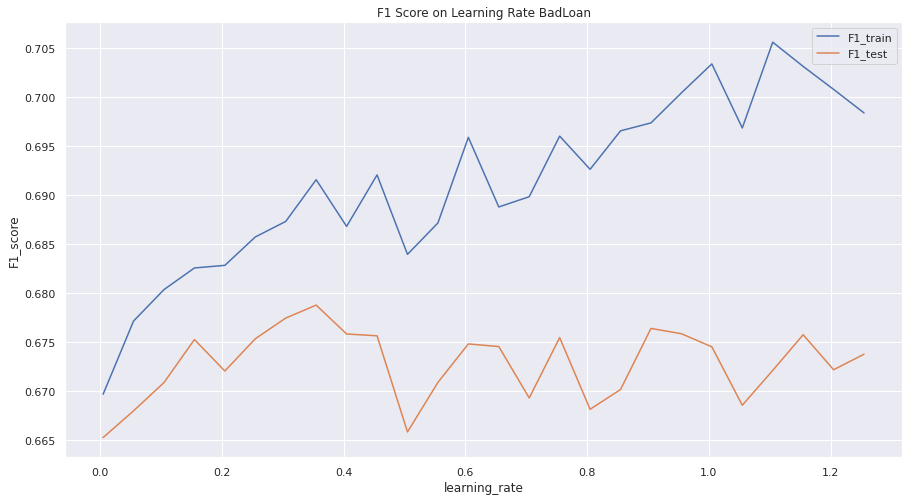

In [89]:
def learningRate(X,Y, learning):
  max_depth = []
  acc_gini = []
  acc_entropy = []
  counter = 0
  # ccp_alphas_sub = ccp_alphas[1::14]
  # ccp_alphas_sub = ccp_alphas_sub[:2]
  for i in learning:
    DT = DecisionTreeClassifier(max_depth = 2, class_weight=None,
                        criterion='entropy')
    model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DT, learning_rate=i,
                        n_estimators=50, random_state=None) 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=150, shuffle = True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    f1_val = f1_score(y_test, y_pred, average='macro')
    train_auc = f1_score(y_train, y_train_pred, average = 'macro')
    # auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.5)
    acc_entropy.append((f1_val, train_auc))
    counter +=1
    print(counter, (f1_val, train_auc), i)

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
  'learning_rate':pd.Series(learning)})
  print("max alphas index")
  # print(np.argmax(np.asarray(list(zip(*acc_entropy))[0])))
  # print(learning[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  # print(acc_entropy[np.argmax(np.asarray(list(zip(*acc_entropy))[0]))])
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on Learning Rate BadLoan")
  plt.plot('learning_rate','F1_train', data=d, label='F1_train')
  plt.plot('learning_rate','F1_test', data=d, label='F1_test')
  # plt.xscale('log', basex=2)
  plt.xlabel('learning_rate')
  plt.ylabel('F1_score')
  # plt.ylim([0.6,1.1])
  plt.legend()
  return d
learningRate(X_train, y_train, learningLst)

### Final Learn Train

(0.684673005803512, 0.6820517178070289)
(0.6857646319917168, 0.6818940163193623)
(0.672162770849111, 0.6830948825192519)
(0.6698340462910645, 0.6833168502250229)
(0.6761503254483846, 0.6843633245687892)
(0.6782222311520077, 0.6836824418455194)
(0.6728994424337937, 0.6856314757324009)
(0.6770044464174879, 0.6843764783526691)
(0.6738740155647392, 0.6852387115180348)
(0.6752071019601992, 0.6869286660576396)
(0.6708816020949544, 0.6916922339619246)
(0.6718444831550938, 0.6880133044249279)
(0.677422567889774, 0.6870657641372389)
(0.6737611052729355, 0.6918933859030165)
(0.6730076147810258, 0.6998441589665122)
(0.6707175296915477, 0.6940636563708275)
(0.671977414636186, 0.699379813409741)
(0.6653287520744086, 0.6961794486508828)
(0.667656892280971, 0.7180182248878401)
(0.6584176134689832, 0.7306854268924301)
(0.6366733823675909, 0.7745384309635823)
(0.6162223973632218, 0.9354820444906456)
(0.5939206111663304, 1.0)
(0.5944478693740751, 1.0)
sds


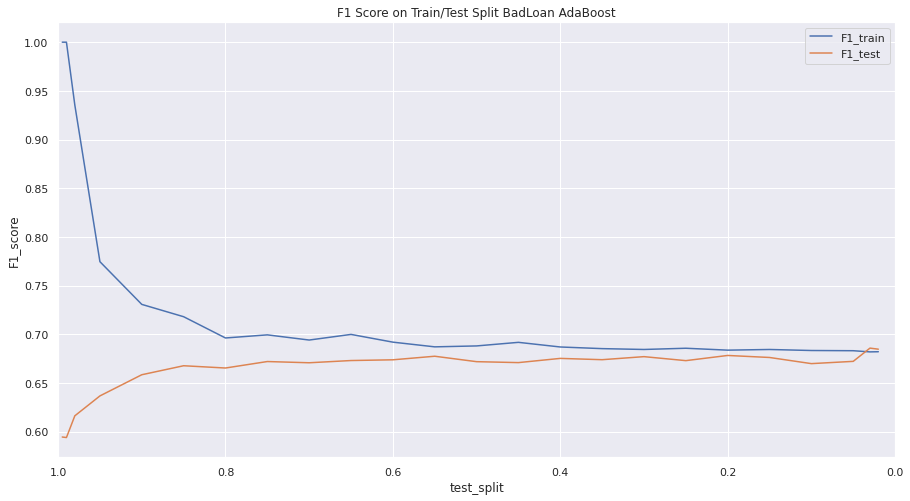

In [90]:
DT = DecisionTreeClassifier(max_depth = 2, class_weight=None,
                    criterion='entropy')
model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DT, learning_rate=0.355,
                    n_estimators=50, random_state=None) 

def get_acc_auc_randomisedCV(X,Y,model, test_percent, iterNo=5 ):
    rs = ShuffleSplit(n_splits=5, test_size=test_percent)
    auclist = []
    train_auc_lst = []
    for train_index, test_index in rs.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        f1_val = f1_score(y_test, y_pred, average='macro')
        auclist.append(f1_val)    
        train_auc = f1_score(y_train, y_train_pred, average = 'macro')
        train_auc_lst.append(train_auc)  
    return (statistics.mean(auclist), statistics.mean(train_auc_lst))

def learningCurveAB(X,Y, model):
  testPercent = np.arange(0.05, 1.0, 0.05)
  testPercent = np.concatenate(( np.asarray([0.02, 0.03]), testPercent, np.asarray([0.98,0.99, 0.995])))
  auclist = []
  for test_range in testPercent:
    auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=test_range)
    auclist.append(auc)
    print(auc)
  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
    'F1_test':pd.Series(list(zip(*auclist))[0]),
  'test_split':pd.Series(testPercent)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on Train/Test Split BadLoan AdaBoost")
  plt.plot('test_split','F1_train', data=d, label='F1_train')
  plt.plot('test_split','F1_test', data=d, label='F1_test')
  plt.xlabel('test_split')
  plt.xlim([1.0,0.0])
  plt.ylabel('F1_score')
  # plt.ylim([0.6,0.8])
  plt.legend()
  return d 

d = learningCurveAB(X_train,y_train, model)

In [73]:
DT = DecisionTreeClassifier(max_depth = 2, class_weight=None,
                    criterion='entropy')
model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DT, learning_rate=0.355,
                    n_estimators=50, random_state=None) 
start = timer()
model.fit(X_train, y_train)
end = timer()
y_pred = model.predict(X_test)
f1_val = f1_score(y_test, y_pred, average='macro')
print(f1_val, end - start)

0.6891823782767306 6.7276052780000555


# KNN

## Weather

In [74]:
X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict, test_size=0.1, random_state=1, shuffle = True)

In [ ]:
def run_randomGrid(X_train, Y_train):
  tuner = dict()
  n_neighbors = [2,5,10,15,20,30]
  p=[1,2,3]
  tuner['n_neighbors'] = n_neighbors
  tuner['p'] = p
  model = KNeighborsClassifier()
  search = RandomizedSearchCV(model, tuner, n_iter=200, scoring='f1_macro', n_jobs=-1, random_state=150)
  search = search.fit(X_train,Y_train)
  return search

In [ ]:
search = run_randomGrid(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 18 is smaller than n_iter=200. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [ ]:
# search = run_randomGrid(X_train, y_train)
print(search.best_params_)
print(search.best_estimator_.score)
print(search.best_score_)

{'p': 1, 'n_neighbors': 5}
<bound method ClassifierMixin.score of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')>
0.5956660028596314


### Learning Curve

In [ ]:
def get_acc_auc_randomisedCV(X,Y,model, test_percent, iterNo=5 ):
    rs = ShuffleSplit(n_splits=5, test_size=test_percent)
    auclist = []
    train_auc_lst = []
    for train_index, test_index in rs.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        f1_val = f1_score(y_test, y_pred, average='macro')
        auclist.append(f1_val)    
        train_auc = f1_score(y_train, y_train_pred, average = 'macro')
        train_auc_lst.append(train_auc) 

        
    return (statistics.mean(auclist), statistics.mean(train_auc_lst))

model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')



(0.5901719234545253, 0.6961458883385513)
(0.6170491162127053, 0.6971189335454493)
(0.5924246879379758, 0.6964979315834161)
(0.5961480800139195, 0.6947813096846273)
(0.6005126207156188, 0.6936537380607496)
(0.5860987896932829, 0.6938946415842318)
(0.5908963665395905, 0.690772903908945)
(0.5910078678406788, 0.6895792984705494)
(0.5880649765813099, 0.6900145733982171)
(0.5941989295053118, 0.6875290093563339)
(0.5862678707542542, 0.6810257270885016)
(0.5802749700887816, 0.6879562901866967)
(0.5782852822918081, 0.6750046305998944)
(0.5811212848331001, 0.6775208508320786)
(0.5792422603883189, 0.6757539309103047)
(0.5729769911271609, 0.6763193621981013)
(0.568642977581983, 0.6659033566272916)
(0.5638187207582672, 0.6615104820476416)
(0.5551473532847616, 0.6538658503902636)
(0.543463851531706, 0.6324656125594705)
(0.5341196220021891, 0.6105006586838498)
(0.52185292953864, 0.6269692508046851)
(0.496415296966982, 0.5175088308906979)
(0.486556448271521, 0.485881941410337)
sds


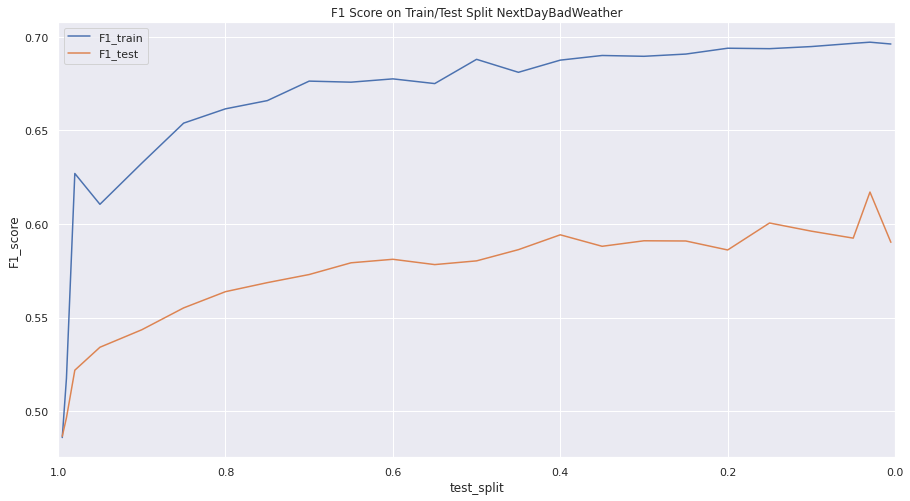

In [ ]:
def learningCurveKNN(X,Y, model):
  testPercent = np.arange(0.05, 1.0, 0.05)
  testPercent = np.concatenate(( np.asarray([0.005,  0.03]), testPercent, np.asarray([0.98,0.99, 0.995])))
  auclist = []
  for test_range in testPercent:
    auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=test_range)
    auclist.append(auc)
    print(auc)
  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
    'F1_test':pd.Series(list(zip(*auclist))[0]),
  'test_split':pd.Series(testPercent)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on Train/Test Split NextDayBadWeather")
  plt.plot('test_split','F1_train', data=d, label='F1_train')
  plt.plot('test_split','F1_test', data=d, label='F1_test')
  plt.xlabel('test_split')
  plt.xlim([1.0,0.0])
  plt.ylabel('F1_score')
  # plt.ylim([0.4,0.75])
  plt.legend()

learningCurveKNN(X_train,y_train, model)

### Number of N

1 (0.6117820882462517, 1.0)
2 (0.5577539739611187, 0.7212515817529245)
3 (0.6048031377679618, 0.7749314159185994)
4 (0.5660789557797345, 0.6499942262831088)
5 (0.6074761848226088, 0.6928826861358203)
6 (0.5573438593300352, 0.6213745991919747)
7 (0.589699352127825, 0.6538226314861545)
8 (0.547811062849823, 0.6001131834260219)
9 (0.5732433472686734, 0.6271203260149278)
10 (0.5426920803776488, 0.5864304293945227)
11 (0.5565345284685257, 0.6076620462158555)
12 (0.530171575539356, 0.5715469687467496)
13 (0.5528612374813, 0.5880119218905783)
14 (0.5305529650227001, 0.5613238227051249)
15 (0.5530764016049171, 0.578556548936541)
16 (0.5277664169832722, 0.5538916537585142)
17 (0.541417169121483, 0.5706132771158241)
18 (0.5228792627681672, 0.5464787169324627)
19 (0.5419464754233739, 0.5590601699496013)
20 (0.517700059158205, 0.5410392816690581)
21 (0.5348652525962456, 0.5528268363266409)
22 (0.5210275191903223, 0.5368717801595441)
23 (0.5208858767533435, 0.5500796757840138)
24 (0.518717407282955

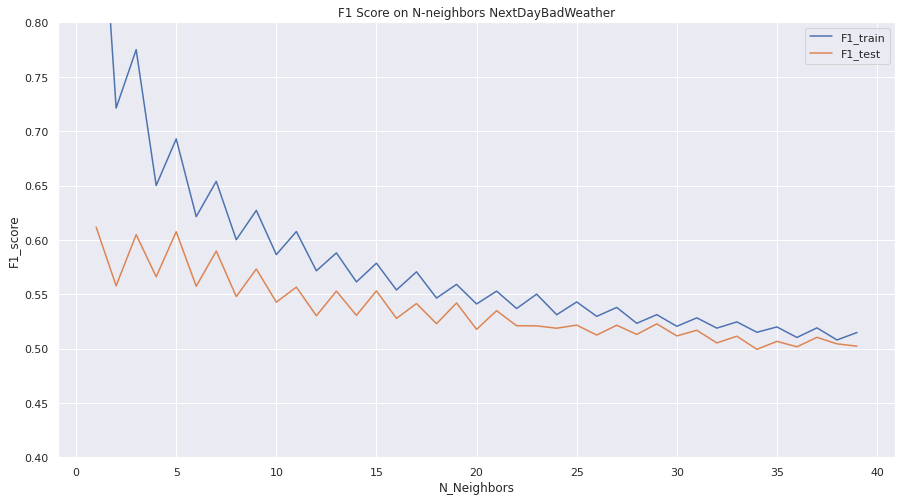

In [ ]:
#improve the bias of the decision tree
def numberN(X,Y):
  max_depth = []
  acc_gini = []
  acc_entropy = []
  for i in range(1,40):
    model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                        metric_params=None, n_jobs=None, n_neighbors=i, p=1,
                        weights='uniform')
    auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.1)
    acc_entropy.append(auc)
    max_depth.append(i)
    print(i, auc)

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
  'N_Neighbors':pd.Series(max_depth)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on N-neighbors NextDayBadWeather")
  plt.plot('N_Neighbors','F1_train', data=d, label='F1_train')
  plt.plot('N_Neighbors','F1_test', data=d, label='F1_test')
  plt.xlabel('N_Neighbors')
  plt.ylabel('F1_score')
  plt.ylim([0.4,0.8])
  plt.legend()
numberN(X_train,y_train)

In [75]:
model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')

start = timer()
model.fit(X_train,y_train)
end = timer()
y_pred = model.predict(X_test)
f1_val = f1_score(y_test, y_pred, average='macro')
print(f1_val, end - start)



0.6050767609376454 0.2607928740001171


## Bad Loan

In [76]:
X_train, X_test, y_train, y_test = train_test_split(defaultRun, defaultPred, test_size=0.1, random_state=1, shuffle = True)
# search = run_randomGrid(X_train, y_train)
# print(search.best_params_)
# print(search.best_estimator_.score)
# print(search.best_score_)

(0.6917075144938175, 0.6897651861783064)
(0.6785416989558837, 0.6889315319923887)
(0.6647744623062645, 0.6901106960048113)
(0.6682528512022435, 0.6890350095371446)
(0.668614741504802, 0.687020791034353)
(0.666516720946235, 0.6878106363263501)
(0.6650935466798262, 0.6862216439734756)
(0.6634032387855736, 0.6862851946770492)
(0.6638464895285598, 0.6851612900635051)
(0.6638246631041183, 0.6849533958117284)
(0.6588834299888182, 0.686831905965898)
(0.6563173332744346, 0.6857687468778902)
(0.6567699672797759, 0.6866357575537742)
(0.6545494796001731, 0.6811685728676006)
(0.6563881649410878, 0.6779950217335063)
(0.6504127634382276, 0.6787468042717293)
(0.6453981087660576, 0.672178987710302)
(0.6375480411982447, 0.6682258378377194)
(0.6355871150397117, 0.6659446787278586)
(0.6243701997632446, 0.6522334083096119)
(0.6069126176756214, 0.6141069978378384)
(0.541947473999782, 0.5817665112784007)
(0.48333987708505133, 0.4854784544185742)
(0.4542703401220654, 0.4791010112336561)
sds


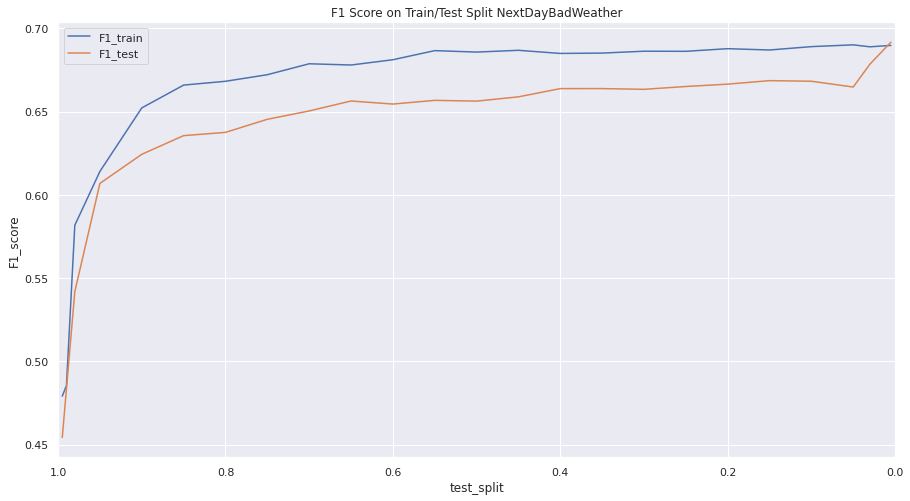

In [58]:
model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=3,
                     weights='uniform')
learningCurveKNN(X_train,y_train, model)

1 (0.6083608717309923, 0.9990192390727157)
2 (0.5859002579766337, 0.7388377467987296)
3 (0.6352507701870181, 0.7824777608373857)
4 (0.6119631584478422, 0.7031971217966053)
5 (0.6430164977332506, 0.7347782627728381)
6 (0.6276084700437667, 0.6907085123605432)
7 (0.6496457232499777, 0.7140328572105943)
8 (0.6470268324497647, 0.6856644648622261)
9 (0.6568039042356483, 0.7045419874006121)
10 (0.6433838871213375, 0.6826096341493089)
11 (0.6675976696881895, 0.6969640273146557)
12 (0.6489185252176657, 0.6820542958146716)
13 (0.661936371756412, 0.6937283495166329)
14 (0.6453373760328346, 0.6804549804713235)
15 (0.6677987451854105, 0.6879920355621011)
16 (0.6572565565137389, 0.6779676438567162)
17 (0.6644887126626067, 0.6878023174894402)
18 (0.6621139949449774, 0.6774418765401267)
19 (0.6693412863107941, 0.6849628643337046)
20 (0.6541007832762123, 0.6788516736368011)
21 (0.6760070813778154, 0.6833485906423719)
22 (0.6600098889359997, 0.675847652531328)
23 (0.666299193654277, 0.6813436293813963)


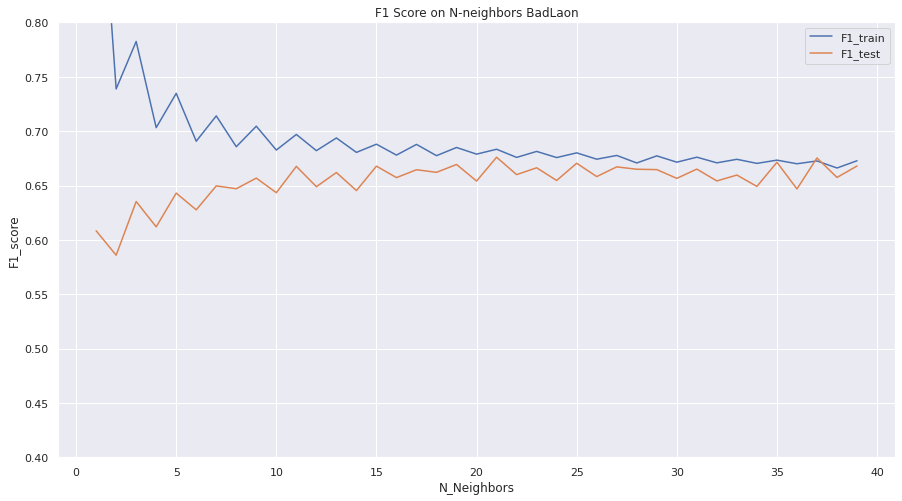

In [60]:
#improve the bias of the decision tree
def numberN(X,Y):
  max_depth = []
  acc_gini = []
  acc_entropy = []
  for i in range(1,40):
    model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=i, p=3,
                     weights='uniform')
    auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=0.1)
    acc_entropy.append(auc)
    max_depth.append(i)
    print(i, auc)

  d = pd.DataFrame({'F1_train':pd.Series(list(zip(*acc_entropy))[1]),
    'F1_test':pd.Series(list(zip(*acc_entropy))[0]),
  'N_Neighbors':pd.Series(max_depth)})
  print("sds")
  plt.figure(figsize=(15,8))
  plt.title("F1 Score on N-neighbors BadLaon")
  plt.plot('N_Neighbors','F1_train', data=d, label='F1_train')
  plt.plot('N_Neighbors','F1_test', data=d, label='F1_test')
  plt.xlabel('N_Neighbors')
  plt.ylabel('F1_score')
  plt.ylim([0.4,0.8])
  plt.legend()
numberN(X_train,y_train)

In [ ]:
def learningCurveKNN(X,Y, model):
    testPercent = np.arange(0.05, 1.0, 0.05)
    testPercent = np.concatenate(( np.asarray([0.005,  0.03]), testPercent, np.asarray([0.98,0.99, 0.995])))
    auclist = []
    for test_range in testPercent:
        auc = get_acc_auc_randomisedCV(X, Y, model, test_percent=test_range)
        auclist.append(auc)
        print(auc)
    d = pd.DataFrame({'F1_train':pd.Series(list(zip(*auclist))[1]),
    'F1_test':pd.Series(list(zip(*auclist))[0]),
    'test_split':pd.Series(testPercent)})
    print("sds")
    plt.figure(figsize=(15,8))
    plt.title("F1 Score on Train/Test Split Bad loan")
    plt.plot('test_split','F1_train', data=d, label='F1_train')
    plt.plot('test_split','F1_test', data=d, label='F1_test')
    plt.xlabel('test_split')
    plt.xlim([1.0,0.0])
    plt.ylabel('F1_score')
    # plt.ylim([0.4,0.75])
    plt.legend()

In [77]:
model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                  metric_params=None, n_jobs=None, n_neighbors=21, p=3,
                  weights='uniform')
learningCurveKNN(X_train,y_train, model)

In [78]:
start = timer()
model.fit(X_train,y_train)
end = timer()
y_pred = model.predict(X_test)
f1_val = f1_score(y_test, y_pred, average='macro')
print(f1_val, end -start)

0.22238248000007843


# SVC Bad  Weather

In [ ]:

#   {'kernel': ['linear'], 'C': [1, 10, 100, 200]}
def run_randomGrid(X_train, Y_train):
    tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100]}
                      
    model = SVC()
    search = GridSearchCV(model, tuned_parameters,refit = True, scoring = 'f1_macro')
    search = search.fit(X_train,Y_train)
    return search

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(nextRainData, nexRainPredict, test_size=0.1, random_state=1, shuffle = True)

In [ ]:
def run_randomGridLinear(X_train, Y_train):
    tuned_parameters = {'kernel': ['linear'], 'C': [1, 10, 100, 200]}
                      
    model = SVC()
    search = GridSearchCV(model, tuned_parameters,refit = True, scoring = 'f1_macro')
    search = search.fit(X_train,Y_train)
    return search
searchlinear = run_randomGridLinear(X_train,y_train )

In [ ]:
print(searchrbf.best_params_)
print(searchrbf.best_estimator_.score)
print(searchrbf.best_score_)

In [ ]:
print(searchlinear.best_params_)
print(searchlinear.best_estimator_.score)
print(searchlinear.best_score_)

## Learning Curve Inital Model

In [ ]:
firstL = SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

firstG = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
def train_model(X,Y,model):
    testPercent = np.arange(0.1, 1.0, 0.1)
    testPercent = np.concatenate(( np.asarray([0.005, 0.02, 0.03]), testPercent, np.asarray([0.98,0.99, 0.995])))
    auclist = []
    train_auc_lst = []
    
    
    clock_lst = []
    for i in testPercent:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=i, random_state=150, shuffle = True)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        auc_score = f1_score(Y_test, y_pred, average='macro')
        train_auc = f1_score(Y_train, y_train_pred, average='macro')
        auclist.append(auc_score)
        train_auc_lst.append(train_auc)


        print(i)
    return (auclist, train_auc_lst, testPercent)
model = SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
auclist, train_auc_lst,  testPercent = train_model(X_train,y_train, firstG)



In [ ]:
d = pd.DataFrame({'auc_train':pd.Series(train_auc_lst),
  'auc_test':pd.Series(auclist),
 'train_split':pd.Series(testPercent),
 })

fig, ax1 = plt.subplots(figsize=(15,8))
# plt.figure(figsize=(15,8))
ax1.set_title("F1 score on Train/Test Split NextDayRain (RBF)")
ax1.plot('train_split','auc_train', data=d, label='train_auc')
ax1.plot('train_split','auc_test', data=d, label='test_auc')
ax1.set_xlabel('train_split')
ax1.set_ylabel('F1')
ax1.set_xlim([1,0.0])
ax1.legend()
plt.show()

## Regularization

In [ ]:
c = [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 500, 700, 1000]

from sklearn.metrics import accuracy_score

def svcKernel(X_train, X_test, Y_train, Y_test):
    max_depth = []
    acc_gini = []
    acc_entropy = []
    cs =  [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 700, 1000]

    for i in cs:
        svc_mod =SVC(C=i, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
          max_iter=-1, probability=False, random_state=None, shrinking=True,
          tol=0.001, verbose=False)
        svc_mod.fit(X_train,Y_train)
        y_pred = svc_mod.predict(X_test)
        y_train_pred = svc_mod.predict(X_train)
        acc_entropy.append(f1_score(Y_test, y_pred, average = 'macro'))
        acc_gini.append(f1_score(Y_train, y_train_pred, average = 'macro'))
        print(i, f1_score(Y_test, y_pred, average = 'macro'))

    ####
    # svc_mod = SVC(kernel='rbf', C= i)
    # svc_mod.fit(X_train,Y_train )
    # y_pred = svc_mod.predict(X_test)
    # acc_entropy.append(roc_auc_score(Y_test, y_pred))
    # max_depth.append(i)
    # print(i, roc_auc_score(Y_test, y_pred))

    return (acc_gini, acc_entropy, cs)

acc_gini, acc_entropy, cs = svcKernel(X_train, X_test, y_train, y_test)
 ####
d = pd.DataFrame({'train':pd.Series(acc_gini), 
 'validation':pd.Series(acc_entropy),
 'C':pd.Series(cs)})
# visualizing changes in parameters
plt.figure(figsize=(15,6))
plt.title("SVC Kernel and C for (Next Day Bad Weather)")
plt.xscale('log',base=10)
plt.plot('C','train', data=d, label='train')
plt.plot('C','validation', data=d, label='validation')
plt.xlabel('C')
plt.ylabel('F1')
plt.legend()

In [ ]:
#final model
## Final learning curve model
model = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
# auclist, train_auc_lst, testPercent = train_model(X_train,y_train, model)
from timeit import default_timer as timer
start = timer()
model.fit(X_train,y_train)
end = timer()
print(end-start)

# SVC Bad Loan

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(defaultRun, defaultPred, test_size=0.6, random_state=1, shuffle = True)


In [ ]:
searchrbf = run_randomGrid(X_train,y_train )
searchlinear = run_randomGridLinear(X_train,y_train )

In [ ]:
print(searchrbf.best_params_)
print(searchrbf.best_estimator_.score)
print(searchrbf.best_score_)

In [ ]:
print(searchlinear.best_params_)
print(searchlinear.best_estimator_.score)
print(searchlinear.best_score_)

In [ ]:
SVC_model =  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
def train_model(X,Y,model):
    testPercent = np.arange(0.1, 1.0, 0.1)
    testPercent = np.concatenate(( np.asarray([0.005, 0.02, 0.03]), testPercent, np.asarray([0.98,0.99, 0.995])))
    auclist = []
    train_auc_lst = []
    clock_lst = []
    for i in testPercent:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=i, random_state=150, shuffle = True)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        auc_score = f1_score(Y_test, y_pred, average='macro')
        train_auc = f1_score(Y_train, y_train_pred, average='macro')
        auclist.append(auc_score)
        train_auc_lst.append(train_auc)
        print(i)
    return (auclist, train_auc_lst, testPercent)
model = SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
auclist, train_auc_lst, testPercent = train_model(X_train,y_train, SVC_model)

In [ ]:
d = pd.DataFrame({'auc_train':pd.Series(train_auc_lst),
  'auc_test':pd.Series(auclist),
 'train_split':pd.Series(testPercent),
 })

fig, ax1 = plt.subplots(figsize=(15,8))
# plt.figure(figsize=(15,8))
ax1.set_title("F1 score on Train/Test Split Badloan RBF")
ax1.plot('train_split','auc_train', data=d, label='train_auc')
ax1.plot('train_split','auc_test', data=d, label='test_auc')
ax1.set_xlabel('train_split')
ax1.set_ylabel('F1')
ax1.set_xlim([1,0])
ax1.legend()
plt.show()

## Regularization

In [ ]:
c = [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 500, 700, 1000]

from sklearn.metrics import accuracy_score

def svcKernel(X_train, X_test, Y_train, Y_test):
    max_depth = []
    acc_gini = []
    acc_entropy = []
    cs =  [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 700, 1000]

    for i in cs:
        svc_mod = SVC(C=i, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
          max_iter=-1, probability=False, random_state=None, shrinking=True,
          tol=0.001, verbose=False)
        svc_mod.fit(X_train,Y_train)
        y_pred = svc_mod.predict(X_test)
        y_train_pred = svc_mod.predict(X_train)
        acc_entropy.append(f1_score(Y_test, y_pred, average = 'macro'))
        acc_gini.append(f1_score(Y_train, y_train_pred, average = 'macro'))
        print(i, f1_score(Y_test, y_pred, average = 'macro'))

    ####
    # svc_mod = SVC(kernel='rbf', C= i)
    # svc_mod.fit(X_train,Y_train )
    # y_pred = svc_mod.predict(X_test)
    # acc_entropy.append(roc_auc_score(Y_test, y_pred))
    # max_depth.append(i)
    # print(i, roc_auc_score(Y_test, y_pred))

    return (acc_gini, acc_entropy, cs)

acc_gini, acc_entropy, cs = svcKernel(X_train, X_test, y_train, y_test)
 ####
d = pd.DataFrame({'train':pd.Series(acc_gini), 
 'validation':pd.Series(acc_entropy),
 'C':pd.Series(cs)})
# visualizing changes in parameters
plt.figure(figsize=(15,6))
plt.title("SVC Kernel and C for (Bad Loan)")
plt.xscale('log',base=10)
plt.plot('C','train', data=d, label='train')
plt.plot('C','validation', data=d, label='validation')
plt.xlabel('C')
plt.ylabel('F1')
plt.legend()

In [ ]:
plt.figure(figsize=(15,6))
plt.title("SVC Kernel and C for (Bad Loan)")
plt.xscale('log',base=10)
plt.plot('C','train', data=d, label='train')
plt.plot('C','validation', data=d, label='validation')
plt.xlabel('C')
plt.ylabel('F1')
plt.legend()


In [ ]:
## Final learning curve model
SVC_model = SVC(C=300, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


def train_model(X,Y,model):
    testPercent = np.arange(0.1, 1.0, 0.1)
    testPercent = np.concatenate(( np.asarray([0.02, 0.03]), testPercent, np.asarray([0.98,0.99, 0.995])))
    auclist = []
    train_auc_lst = []
    clock_lst = []
    for i in testPercent:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=i, random_state=150, shuffle = True)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        auc_score = f1_score(Y_test, y_pred, average='macro')
        train_auc = f1_score(Y_train, y_train_pred, average='macro')
        auclist.append(auc_score)
        train_auc_lst.append(train_auc)
        print(i)
    return (auclist, train_auc_lst, testPercent)
model = SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
auclist, train_auc_lst, testPercent = train_model(X_train,y_train, SVC_model)


In [ ]:
d = pd.DataFrame({'auc_train':pd.Series(train_auc_lst),
  'auc_test':pd.Series(auclist),
 'train_split':pd.Series(testPercent),
 })

fig, ax1 = plt.subplots(figsize=(15,8))
# plt.figure(figsize=(15,8))
ax1.set_title("F1 score on Train/Test Split Badloan")
ax1.plot('train_split','auc_train', data=d, label='train_auc')
ax1.plot('train_split','auc_test', data=d, label='test_auc')
ax1.set_xlabel('train_split')
ax1.set_ylabel('F1')
ax1.set_xlim([1,0])
ax1.legend()
plt.show()

In [ ]:
SVC_model = SVC(C=300, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
start = timer()
SVC_model.fit(X_train,y_train)
end = timer()
y_pred = SVC_model.predict(X_test)

auc_score = f1_score(y_test, y_pred, average='macro')
print(auc_score, end-start)